In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 두 개의 데이터 불러오기
act = pd.read_csv('/Users/jisoyun/Desktop/sparta_python/Healthcare/sparta_15/data/dailyActivity_merged_fin_sum.csv')


# 날짜 컬럼을 datetime으로 변환
act['ActivityDate'] = pd.to_datetime(act['ActivityDate'])

# ★ 같은 날짜 데이터 합치기 (중복 제거 대신)
numeric_cols = act.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('Id') if 'Id' in numeric_cols else None

act = act.groupby(['Id', 'ActivityDate']).agg({
    **{col: 'sum' for col in numeric_cols}
}).reset_index()

# 날짜순 정렬
act = act.sort_values(['Id', 'ActivityDate']).reset_index(drop=True)

print(f"합친 데이터 shape: {act.shape}")
print(f"날짜 범위: {act['ActivityDate'].min()} ~ {act['ActivityDate'].max()}")
print(f"총 사용자 수: {act['Id'].nunique()}명")
print(f"사용자당 평균 기록일: {act.groupby('Id').size().mean():.1f}일")

합친 데이터 shape: (1373, 15)
날짜 범위: 2016-03-12 00:00:00 ~ 2016-05-12 00:00:00
총 사용자 수: 35명
사용자당 평균 기록일: 39.2일


In [2]:
MILE_TO_KM = 1.60934
distance_cols = [
    "TotalDistance","TrackerDistance","LoggedActivitiesDistance",
    "VeryActiveDistance","ModeratelyActiveDistance","LightActiveDistance"
]

for col in distance_cols:
    act[f"{col}_km"] = act[col] * MILE_TO_KM

# sedentaryActiveDistance는 분석에서 제외
act = act.drop(columns=["SedentaryActiveDistance"])


In [3]:
act['Id'] = act['Id'].astype(str)

In [4]:
# 미착용일 제거
non_wear = (act['TotalSteps'] == 0) & (act['TotalDistance_km'] == 0) & (act['SedentaryMinutes'] >= 1380)
print(f"미착용일 수: {non_wear.sum()}개")
act = act[~non_wear].copy()

# 파생 변수 생성
act['weekday'] = act['ActivityDate'].dt.day_name()
act['is_weekend'] = act['weekday'].isin(['Saturday', 'Sunday'])
act['TotalActiveMinutes'] = (
    act['VeryActiveMinutes'] + 
    act['FairlyActiveMinutes'] + 
    act['LightlyActiveMinutes']
)

미착용일 수: 124개


In [5]:
#최소활동 필터링 
# 최소한의 활동이 있는 데이터만 사용
act_filtered = act[
    (act['TotalSteps'] > 1000) & 
    (act['TotalDistance_km'] > 0.5) &
    (act['TotalActiveMinutes'] > 30)
]
print(f"최소 활동 필터링 : {len(act_filtered)}개")
print(f"걸러진 행: {len(act) - len(act_filtered)}개")


최소 활동 필터링 : 1173개
걸러진 행: 76개


In [13]:
distance_columns = [col for col in act.columns if 'Distance' in col]
for col in distance_columns:
    act_filtered[col] = act_filtered[col].round(3)

act_filtered1 = act_filtered.copy()

In [14]:
act_filtered1.columns


Index(['Id', 'ActivityDate', 'TotalSteps', 'TotalDistance', 'TrackerDistance',
       'LoggedActivitiesDistance', 'VeryActiveDistance',
       'ModeratelyActiveDistance', 'LightActiveDistance', 'VeryActiveMinutes',
       'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes',
       'Calories', 'TotalDistance_km', 'TrackerDistance_km',
       'LoggedActivitiesDistance_km', 'VeryActiveDistance_km',
       'ModeratelyActiveDistance_km', 'LightActiveDistance_km', 'weekday',
       'is_weekend', 'TotalActiveMinutes'],
      dtype='object')

In [16]:
# 2-2. Calorie 그룹 추가
bins = [1000, 1500, 2000, 2500, float('inf')]
labels = ['1000-1500', '1500-2000', '2000-2500', '2500 이상']
act_filtered1['CalorieGroup'] = pd.cut(act_filtered1['Calories'], bins=bins, labels=labels, right=False)

print("✓ CalorieGroup 컬럼 추가 완료")
print(f"\n칼로리 그룹별 데이터 개수:")
print(act_filtered1['CalorieGroup'].value_counts().sort_index())

✓ CalorieGroup 컬럼 추가 완료

칼로리 그룹별 데이터 개수:
CalorieGroup
1000-1500     86
1500-2000    307
2000-2500    314
2500 이상      463
Name: count, dtype: int64


In [17]:
# act를 actcp로 복사
actcp = act_filtered1.copy()
print(f"✓ actcp 생성 완료 (행 개수: {len(actcp)})")

✓ actcp 생성 완료 (행 개수: 1173)


In [18]:
# 3-1. 0값 확인
print("=== 0값 확인 ===")
numeric_cols = ['TotalSteps', 'TotalDistance_km', 'TrackerDistance_km',
                'LoggedActivitiesDistance_km', 'VeryActiveDistance_km',
                'ModeratelyActiveDistance_km', 'LightActiveDistance_km',
                'VeryActiveMinutes','FairlyActiveMinutes', 
                'LightlyActiveMinutes', 
                'SedentaryMinutes', 'Calories']

for col in numeric_cols:
    zero_count = (actcp[col] == 0).sum()
    if zero_count > 0:
        print(f"{col}: {zero_count}개 ({zero_count/len(actcp)*100:.1f}%)")

=== 0값 확인 ===
TrackerDistance_km: 3개 (0.3%)
LoggedActivitiesDistance_km: 1120개 (95.5%)
VeryActiveDistance_km: 444개 (37.9%)
ModeratelyActiveDistance_km: 399개 (34.0%)
LightActiveDistance_km: 1개 (0.1%)
VeryActiveMinutes: 439개 (37.4%)
FairlyActiveMinutes: 397개 (33.8%)
LightlyActiveMinutes: 1개 (0.1%)


In [19]:
# 3-3. 이상치 확인 (IQR 방법)
print("\n=== IQR 방법 이상치 개수 ===")

outlier_cols = ['TotalSteps', 'TotalDistance_km', 'TrackerDistance_km',
                'LoggedActivitiesDistance_km', 'VeryActiveDistance_km',
                'ModeratelyActiveDistance_km', 'LightActiveDistance_km',
                'VeryActiveMinutes','FairlyActiveMinutes', 
                'LightlyActiveMinutes', 
                'SedentaryMinutes', 'Calories']

for col in outlier_cols:
    Q1 = actcp[col].quantile(0.25)
    Q3 = actcp[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = actcp[(actcp[col] < lower_bound) | (actcp[col] > upper_bound)]
    
    if len(outliers) > 0:
        print(f"{col}: {len(outliers)}개 (하한: {lower_bound:.2f}, 상한: {upper_bound:.2f})")


=== IQR 방법 이상치 개수 ===
TotalSteps: 22개 (하한: -4227.50, 상한: 20456.50)
TotalDistance_km: 34개 (하한: -5.38, 상한: 23.91)
TrackerDistance_km: 34개 (하한: -5.42, 상한: 23.88)
LoggedActivitiesDistance_km: 53개 (하한: 0.00, 상한: 0.00)
VeryActiveDistance_km: 87개 (하한: -5.48, 상한: 9.13)
ModeratelyActiveDistance_km: 63개 (하한: -2.15, 상한: 3.58)
LightActiveDistance_km: 12개 (하한: -2.09, 상한: 14.00)
VeryActiveMinutes: 78개 (하한: -52.50, 상한: 87.50)
FairlyActiveMinutes: 55개 (하한: -33.00, 상한: 55.00)
LightlyActiveMinutes: 13개 (하한: -29.00, 상한: 459.00)
SedentaryMinutes: 4개 (하한: 31.00, 상한: 1871.00)
Calories: 11개 (하한: 434.50, 상한: 4294.50)


In [20]:
# 3-4. 이상치 제거
def remove_outliers_iqr(df, columns):
    """IQR 방법으로 이상치 제거"""
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 이상치 제거
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

# 이상치 제거할 주요 컬럼
outlier_cols = ['TotalSteps', 'TotalDistance_km', 'TrackerDistance_km',
                'LoggedActivitiesDistance_km', 'VeryActiveDistance_km',
                'ModeratelyActiveDistance_km', 'LightActiveDistance_km',
                'VeryActiveMinutes','FairlyActiveMinutes', 
                'LightlyActiveMinutes', 
                'SedentaryMinutes', 'Calories']

print(f"이상치 제거 전: {len(actcp)}행")
actcp_final = remove_outliers_iqr(actcp, outlier_cols)
print(f"이상치 제거 후: {len(actcp_final)}행")
print(f"제거된 행: {len(actcp) - len(actcp_final)}행")
print("✓ 이상치 제거 완료")

이상치 제거 전: 1173행
이상치 제거 후: 857행
제거된 행: 316행
✓ 이상치 제거 완료


In [21]:
# 4-1. 최종 데이터 정보
print("=== 최종 데이터 정보 ===")
print(f"행 개수: {len(actcp_final)}")
print(f"열 개수: {len(actcp_final.columns)}")
print(f"\n데이터 타입:\n{actcp_final.dtypes}")


=== 최종 데이터 정보 ===
행 개수: 857
열 개수: 24

데이터 타입:
Id                                     object
ActivityDate                   datetime64[ns]
TotalSteps                              int64
TotalDistance                         float64
TrackerDistance                       float64
LoggedActivitiesDistance              float64
VeryActiveDistance                    float64
ModeratelyActiveDistance              float64
LightActiveDistance                   float64
VeryActiveMinutes                       int64
FairlyActiveMinutes                     int64
LightlyActiveMinutes                    int64
SedentaryMinutes                        int64
Calories                                int64
TotalDistance_km                      float64
TrackerDistance_km                    float64
LoggedActivitiesDistance_km           float64
VeryActiveDistance_km                 float64
ModeratelyActiveDistance_km           float64
LightActiveDistance_km                float64
weekday                           

In [22]:
# 4-2. 주요 컬럼 통계
print("\n=== 주요 컬럼 기본 통계량 ===")
display(actcp_final[['TotalSteps', 'TotalDistance_km', 'Calories', 'VeryActiveMinutes', 'SedentaryMinutes']].describe().round(2))




=== 주요 컬럼 기본 통계량 ===


,TotalSteps,TotalDistance_km,Calories,VeryActiveMinutes,SedentaryMinutes
count,857.00,857.00,857.00,857.00,857.00
mean,6866.26,7.65,2167.10,10.54,963.86
std,3404.30,3.80,504.19,15.05,273.11
min,1004.00,1.05,928.00,0.00,125.00
25%,4131.00,4.52,1819.00,0.00,732.00
50%,6633.00,7.40,2095.00,1.00,1018.00
75%,9471.00,10.51,2525.00,19.00,1195.00
max,16901.00,18.35,3439.00,59.00,1729.00



=== 칼로리 그룹별 분포 ===
CalorieGroup
1000-1500     82
1500-2000    277
2000-2500    275
2500 이상      222
Name: count, dtype: int64


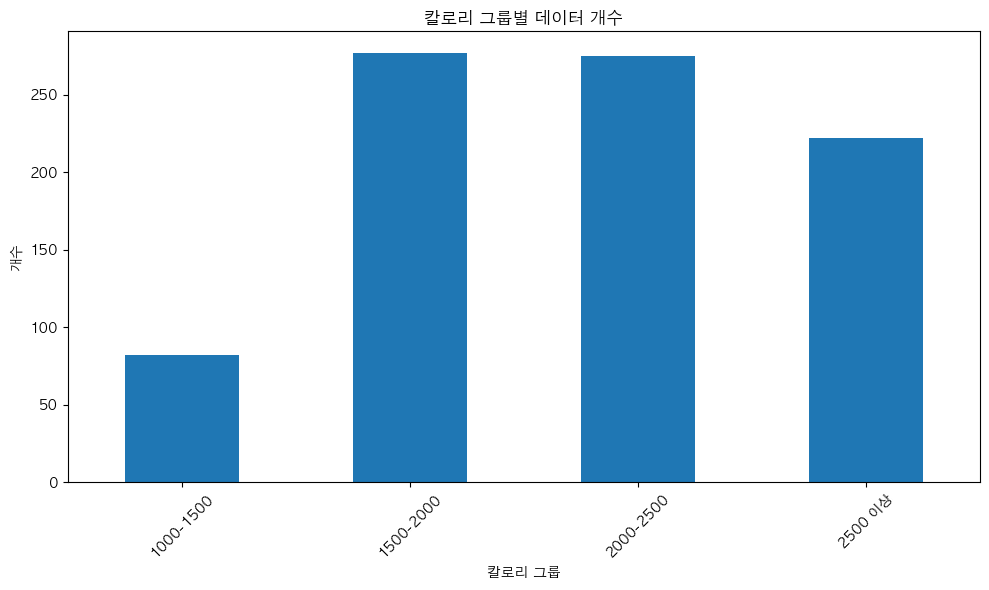

In [23]:
# 4-3. 칼로리 그룹별 분포
print("\n=== 칼로리 그룹별 분포 ===")
print(actcp_final['CalorieGroup'].value_counts().sort_index())

# 시각화
plt.figure(figsize=(10, 6))
actcp_final['CalorieGroup'].value_counts().sort_index().plot(kind='bar')
plt.title('칼로리 그룹별 데이터 개수')
plt.xlabel('칼로리 그룹')
plt.ylabel('개수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
actcp_d = actcp_final.copy()

In [25]:
# 칼로리 그룹별 평균 계산
distance_cols = ['TotalSteps', 'TotalDistance_km', 'TrackerDistance_km', 
                 'VeryActiveDistance_km', 'ModeratelyActiveDistance_km', 'LightActiveDistance_km']

calorie_group_dis = actcp_d.groupby('CalorieGroup', observed=True)[distance_cols].mean().round(3)
print("\n=== 칼로리 그룹별 거리 평균 ===")
calorie_group_dis



=== 칼로리 그룹별 거리 평균 ===


,TotalSteps,TotalDistance_km,TrackerDistance_km,VeryActiveDistance_km,ModeratelyActiveDistance_km,LightActiveDistance_km
CalorieGroup,,,,,,
1000-1500,3532.598,3.732,3.732,0.156,0.090,3.475
1500-2000,6406.653,6.831,6.831,1.088,0.506,5.218
2000-2500,7406.731,8.103,8.103,1.342,0.695,6.040
2500 이상,8016.369,9.581,9.581,1.367,0.769,7.314


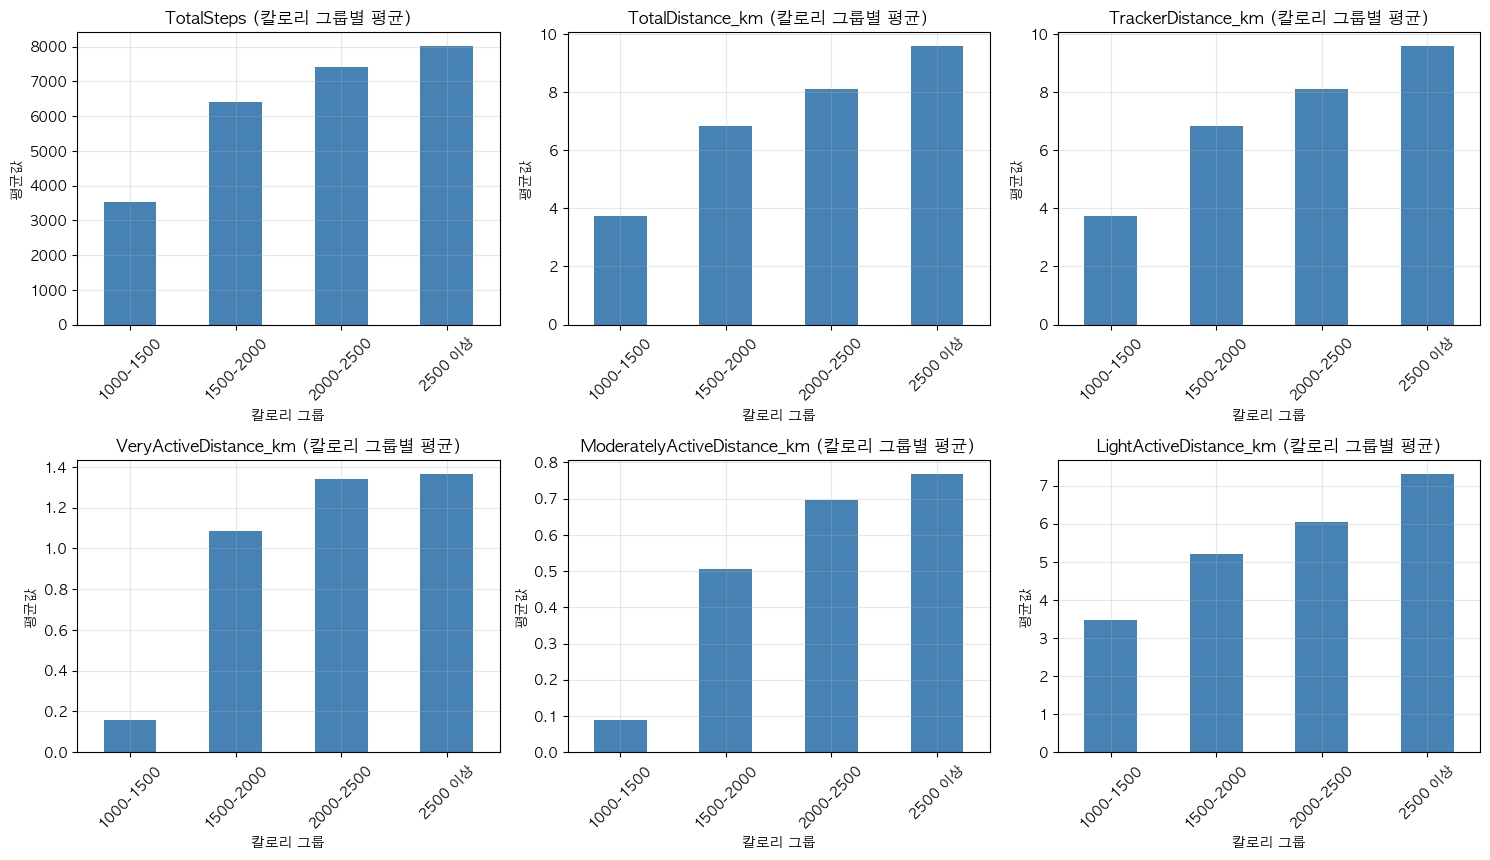

In [26]:
# 시각화 - 각 컬럼별로 그래프
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(distance_cols):
    calorie_group_dis[col].plot(kind='bar', ax=axes[idx], color='steelblue')
    axes[idx].set_title(f'{col} (칼로리 그룹별 평균)')
    axes[idx].set_xlabel('칼로리 그룹')
    axes[idx].set_ylabel('평균값')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)

# 남은 subplot 제거
for idx in range(len(distance_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [27]:
# 칼로리 그룹별 활동 시간 평균 계산
activity_cols = ['VeryActiveMinutes', 'FairlyActiveMinutes', 
                'LightlyActiveMinutes', 'SedentaryMinutes']

calorie_group_t = actcp_d.groupby('CalorieGroup', observed=True)[activity_cols].mean().round(3)
print("\n=== 칼로리 그룹별 활동 시간 평균 ===")
calorie_group_t


=== 칼로리 그룹별 활동 시간 평균 ===


,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes
CalorieGroup,,,,
1000-1500,1.366,1.171,142.085,992.951
1500-2000,9.444,6.931,214.599,975.022
2000-2500,12.222,9.749,238.822,940.673
2500 이상,13.248,12.243,231.536,971.680


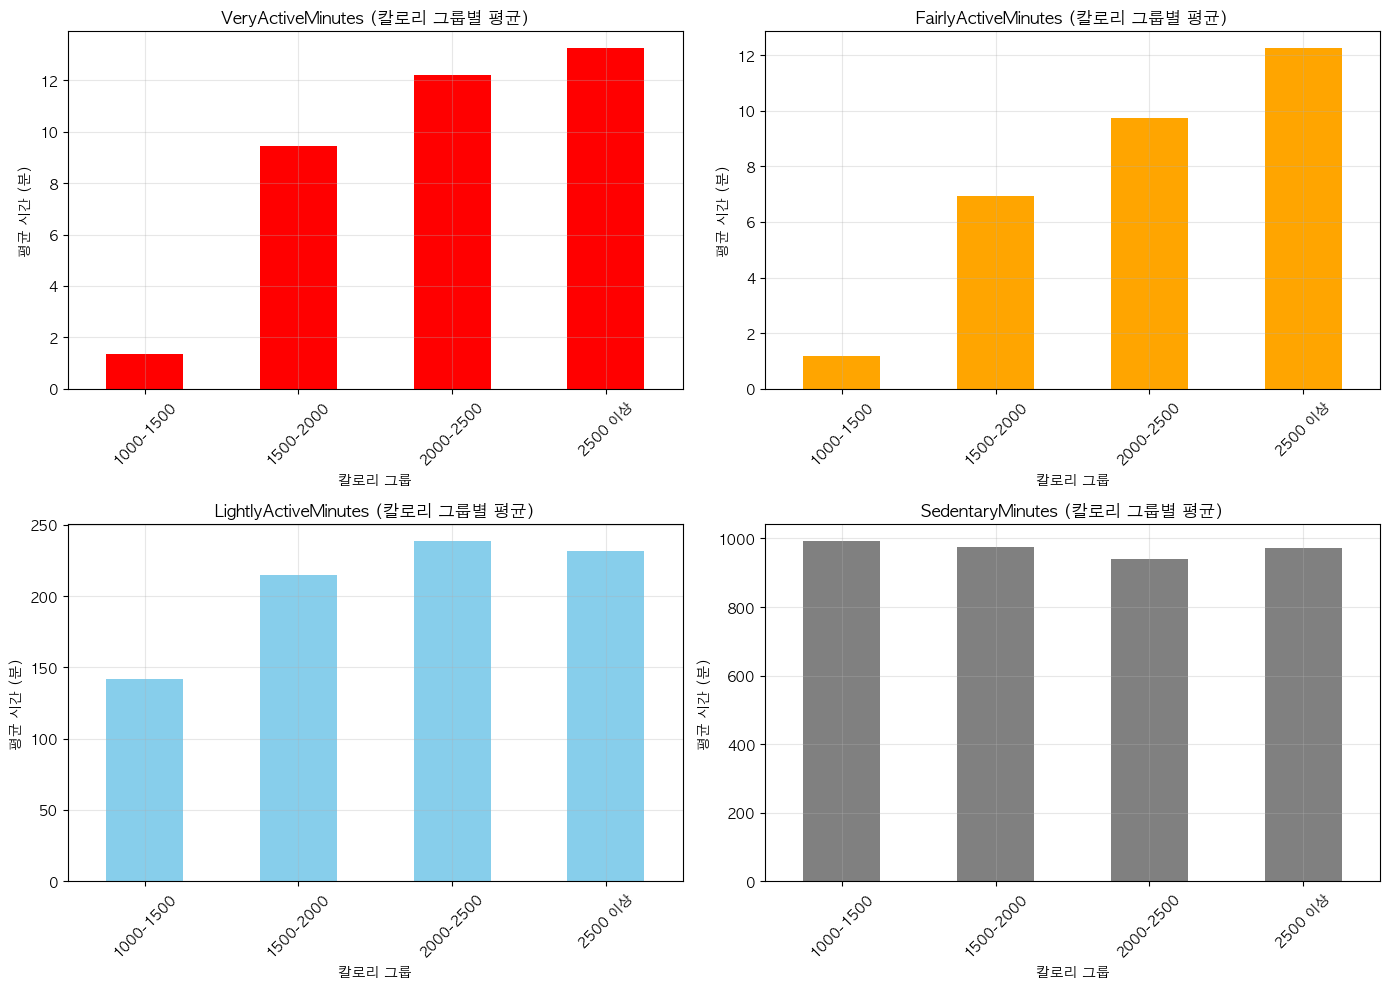

In [28]:
# 시각화 - 각 활동 시간별로 그래프
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = ['red', 'orange', 'skyblue', 'gray']

for idx, col in enumerate(activity_cols):
    calorie_group_t[col].plot(kind='bar', ax=axes[idx], color=colors[idx])
    axes[idx].set_title(f'{col} (칼로리 그룹별 평균)', fontsize=12)
    axes[idx].set_xlabel('칼로리 그룹')
    axes[idx].set_ylabel('평균 시간 (분)')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
# 데이터프레임으로 보기 좋게 출력
print("\n=== 칼로리 그룹별 활동 시간 상세 통계 ===")
display(calorie_group_t)

# 총 활동 시간도 계산
calorie_group_t['TotalActiveMinutes'] = (
    calorie_group_t['VeryActiveMinutes'] + 
    calorie_group_t['FairlyActiveMinutes'] +
    calorie_group_t['LightlyActiveMinutes']
).round(3)

print("\n=== 총 활동 시간 포함 ===")
display(calorie_group_t)


=== 칼로리 그룹별 활동 시간 상세 통계 ===


,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes
CalorieGroup,,,,
1000-1500,1.366,1.171,142.085,992.951
1500-2000,9.444,6.931,214.599,975.022
2000-2500,12.222,9.749,238.822,940.673
2500 이상,13.248,12.243,231.536,971.680



=== 총 활동 시간 포함 ===


,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,TotalActiveMinutes
CalorieGroup,,,,,
1000-1500,1.366,1.171,142.085,992.951,144.622
1500-2000,9.444,6.931,214.599,975.022,230.974
2000-2500,12.222,9.749,238.822,940.673,260.793
2500 이상,13.248,12.243,231.536,971.680,257.027


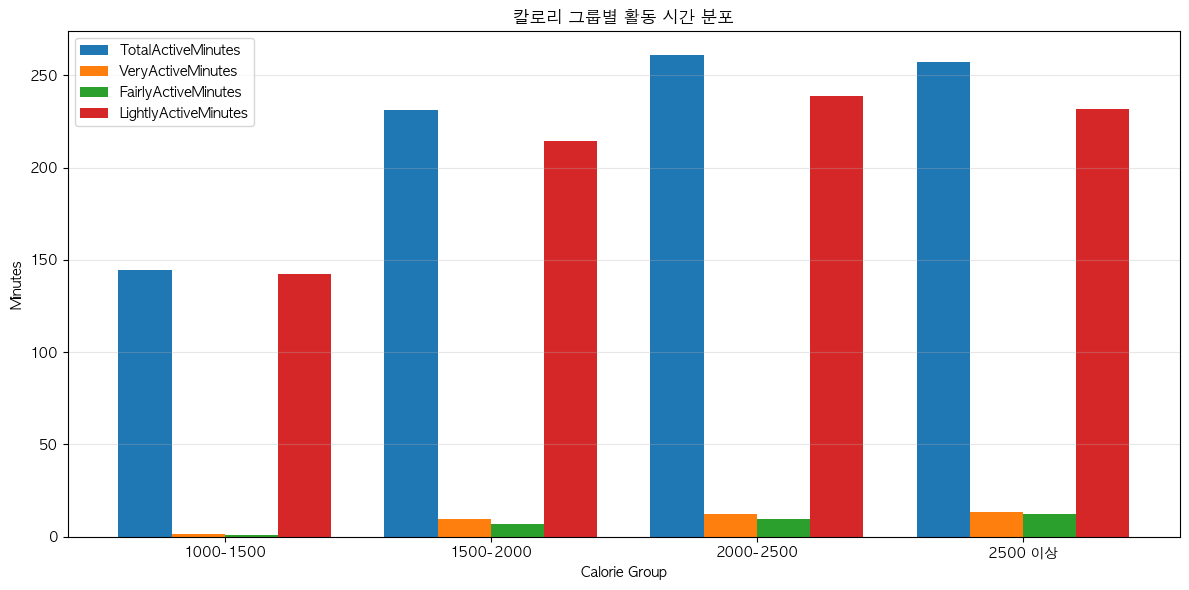

In [30]:

cols = [
    "TotalActiveMinutes",
    "VeryActiveMinutes",
    "FairlyActiveMinutes",
    "LightlyActiveMinutes"
]

data = calorie_group_t[cols]

x = np.arange(len(data.index))
width = 0.2

plt.figure(figsize=(12,6))

for i, col in enumerate(cols):
    plt.bar(x + i*width, data[col], width, label=col)

plt.xticks(x + width*1.5, data.index)
plt.xlabel("Calorie Group")
plt.ylabel("Minutes")
plt.title("칼로리 그룹별 활동 시간 분포")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


In [31]:
# 1. 파생 변수 생성
actcp_d["TotalActiveMinutes"] = (
    actcp_d["VeryActiveMinutes"] + actcp_d["FairlyActiveMinutes"] + actcp_d["LightlyActiveMinutes"]
)

# 평균 속도 (km/h)
actcp_d["AvgSpeed_kmh"] = np.where(
    actcp_d["TotalActiveMinutes"] > 0,
    actcp_d["TotalDistance_km"] / (actcp_d["TotalActiveMinutes"] / 60),
    np.nan
)

# 평균 페이스 (min/km)
actcp_d["AvgPace_min_per_km"] = np.where(
    actcp_d["TotalDistance_km"] > 0,
    actcp_d["TotalActiveMinutes"] / actcp_d["TotalDistance_km"],
    np.nan
)

# 평균 보폭 (m)
actcp_d["AvgStride_m"] = np.where(
    actcp_d["TotalSteps"] > 0,
    (actcp_d["TotalDistance_km"] * 1000) / actcp_d["TotalSteps"],
    np.nan
)

# 고강도 활동 비율
actcp_d["VeryActiveRatio"] = np.where(
    actcp_d["TotalActiveMinutes"] > 0,
    actcp_d["VeryActiveMinutes"] / actcp_d["TotalActiveMinutes"],
    0
)

# 중강도 활동 비율
actcp_d["ModerateActiveRatio"] = np.where(
    actcp_d["TotalActiveMinutes"] > 0,
    actcp_d["FairlyActiveMinutes"] / actcp_d["TotalActiveMinutes"],
    0
)

# 저강도 활동 비율
actcp_d["LightActiveRatio"] = np.where(
    actcp_d["TotalActiveMinutes"] > 0,
    actcp_d["LightlyActiveMinutes"] / actcp_d["TotalActiveMinutes"],
    0
)

# 칼로리 효율
actcp_d["CaloriesPerKm"] = np.where(
    actcp_d["TotalDistance_km"] > 0,
    actcp_d["Calories"] / actcp_d["TotalDistance_km"],
    np.nan
)

# 2. NaN 제거 (중요!)
actcp_d = actcp_d.dropna(subset=['AvgSpeed_kmh', 'AvgPace_min_per_km', 
                                  'AvgStride_m', 'CaloriesPerKm'])

print(f"NaN 제거 후: {len(actcp_d)}행")



NaN 제거 후: 857행


In [32]:

# 1. 이상치 제거 함수
def remove_outliers_iqr(df, columns):
    """IQR 방법으로 이상치 제거"""
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        before_count = len(df_clean)
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
        after_count = len(df_clean)
        
        print(f"  - {col}: {before_count - after_count}개 제거 (기준: {lower_bound:.1f} ~ {upper_bound:.1f})")
    
    return df_clean


# 2. 이상치 제거 실행
outlier_cols = ['TotalActiveMinutes', 'AvgSpeed_kmh', 'AvgPace_min_per_km', 
                'AvgStride_m', 'VeryActiveRatio', "ModerateActiveRatio", 'LightActiveRatio', 'CaloriesPerKm']

print("=== IQR 이상치 제거 ===")
before_len = len(actcp_d)
print(f"이상치 제거 전: {before_len}행")

actcp_d_clean = remove_outliers_iqr(actcp_d, outlier_cols)

print(f"\n이상치 제거 후: {len(actcp_d_clean)}행")
print(f"총 제거된 행: {before_len - len(actcp_d_clean)}행 ({(before_len - len(actcp_d_clean))/before_len*100:.1f}%)")

print("✓ 이상치 제거 완료")

# 4. 그룹별 파생 변수 평균 계산
derived_cols = ['TotalActiveMinutes', 'AvgSpeed_kmh', 'AvgPace_min_per_km', 
                'AvgStride_m', 'VeryActiveRatio',"ModerateActiveRatio", 'LightActiveRatio', 'CaloriesPerKm']

calorie_group_derived = actcp_d_clean.groupby('CalorieGroup', observed=True)[derived_cols].mean().round(3)

print("\n=== 칼로리 그룹별 파생 변수 평균 ===")
display(calorie_group_derived)

=== IQR 이상치 제거 ===
이상치 제거 전: 857행
  - TotalActiveMinutes: 0개 제거 (기준: -44.0 ~ 524.0)
  - AvgSpeed_kmh: 10개 제거 (기준: -0.1 ~ 3.9)
  - AvgPace_min_per_km: 2개 제거 (기준: -1.7 ~ 70.4)
  - AvgStride_m: 36개 제거 (기준: 0.9 ~ 1.3)
  - VeryActiveRatio: 21개 제거 (기준: -0.1 ~ 0.2)
  - ModerateActiveRatio: 19개 제거 (기준: -0.1 ~ 0.1)
  - LightActiveRatio: 0개 제거 (기준: 0.7 ~ 1.2)
  - CaloriesPerKm: 66개 제거 (기준: -117.7 ~ 773.1)

이상치 제거 후: 703행
총 제거된 행: 154행 (18.0%)
✓ 이상치 제거 완료

=== 칼로리 그룹별 파생 변수 평균 ===


,TotalActiveMinutes,AvgSpeed_kmh,AvgPace_min_per_km,AvgStride_m,VeryActiveRatio,ModerateActiveRatio,LightActiveRatio,CaloriesPerKm
CalorieGroup,,,,,,,,
1000-1500,161.523,1.583,42.504,1.048,0.010,0.009,0.980,399.376
1500-2000,248.717,1.752,37.405,1.068,0.035,0.027,0.938,295.952
2000-2500,289.177,1.888,34.382,1.099,0.045,0.034,0.921,295.954
2500 이상,267.175,2.167,29.669,1.180,0.050,0.041,0.909,341.668


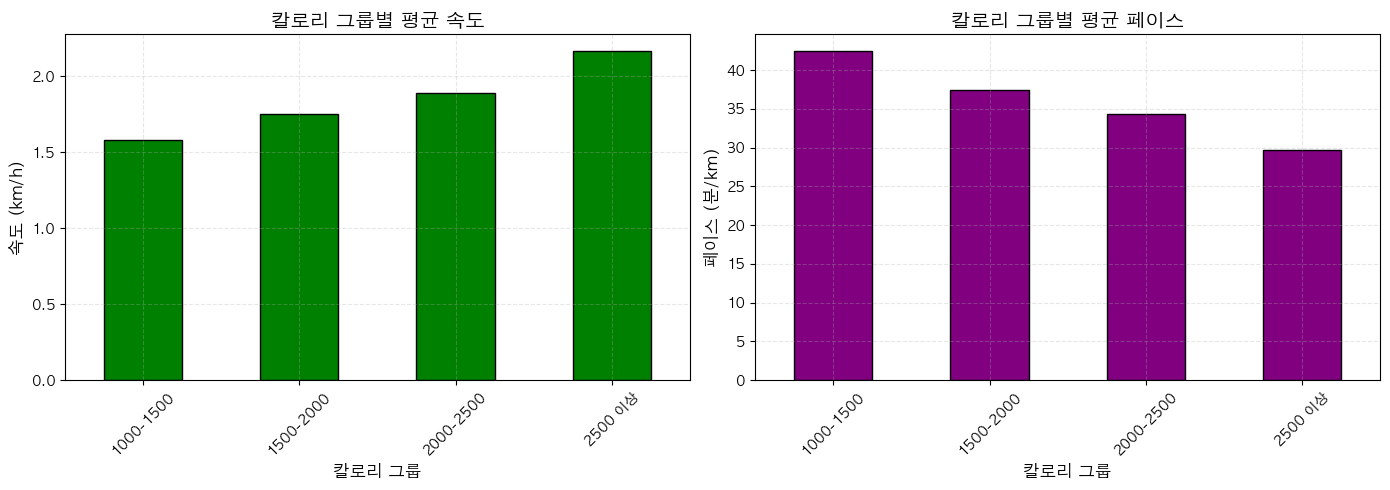

In [33]:
# 1. 속도와 페이스 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 평균 속도
calorie_group_derived['AvgSpeed_kmh'].plot(kind='bar', ax=axes[0], color='green', edgecolor='black')
axes[0].set_title('칼로리 그룹별 평균 속도', fontsize=14, fontweight='bold')
axes[0].set_xlabel('칼로리 그룹', fontsize=12)
axes[0].set_ylabel('속도 (km/h)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, linestyle='--')

# 평균 페이스
calorie_group_derived['AvgPace_min_per_km'].plot(kind='bar', ax=axes[1], color='purple', edgecolor='black')
axes[1].set_title('칼로리 그룹별 평균 페이스', fontsize=14, fontweight='bold')
axes[1].set_xlabel('칼로리 그룹', fontsize=12)
axes[1].set_ylabel('페이스 (분/km)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

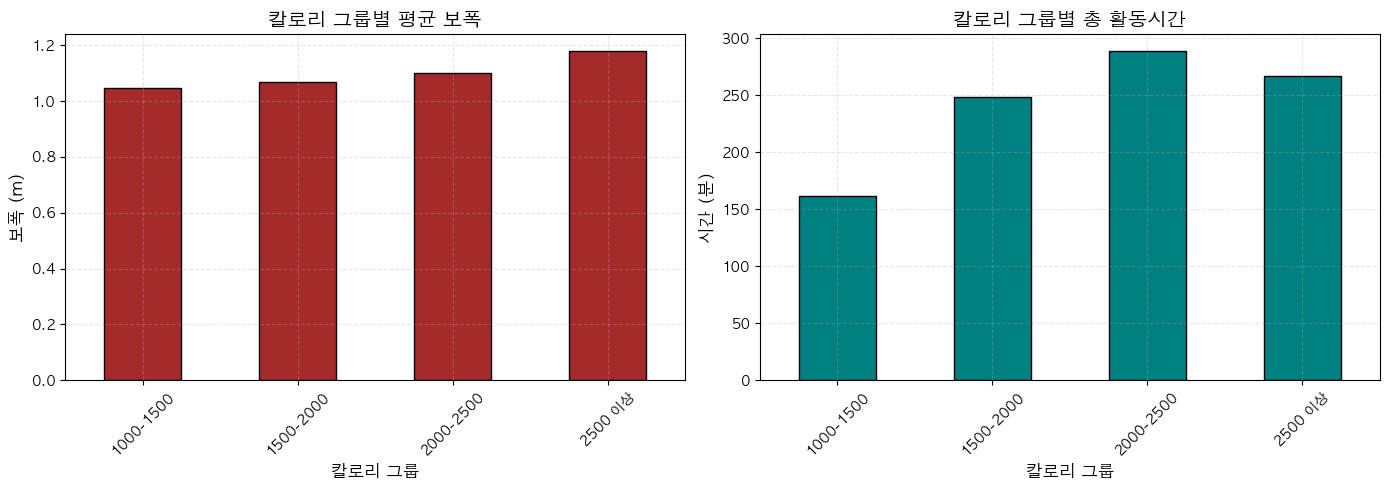

In [34]:
# 2. 보폭과 총 활동시간
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 평균 보폭
calorie_group_derived['AvgStride_m'].plot(kind='bar', ax=axes[0], color='brown', edgecolor='black')
axes[0].set_title('칼로리 그룹별 평균 보폭', fontsize=14, fontweight='bold')
axes[0].set_xlabel('칼로리 그룹', fontsize=12)
axes[0].set_ylabel('보폭 (m)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, linestyle='--')

# 총 활동시간
calorie_group_derived['TotalActiveMinutes'].plot(kind='bar', ax=axes[1], color='teal', edgecolor='black')
axes[1].set_title('칼로리 그룹별 총 활동시간', fontsize=14, fontweight='bold')
axes[1].set_xlabel('칼로리 그룹', fontsize=12)
axes[1].set_ylabel('시간 (분)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

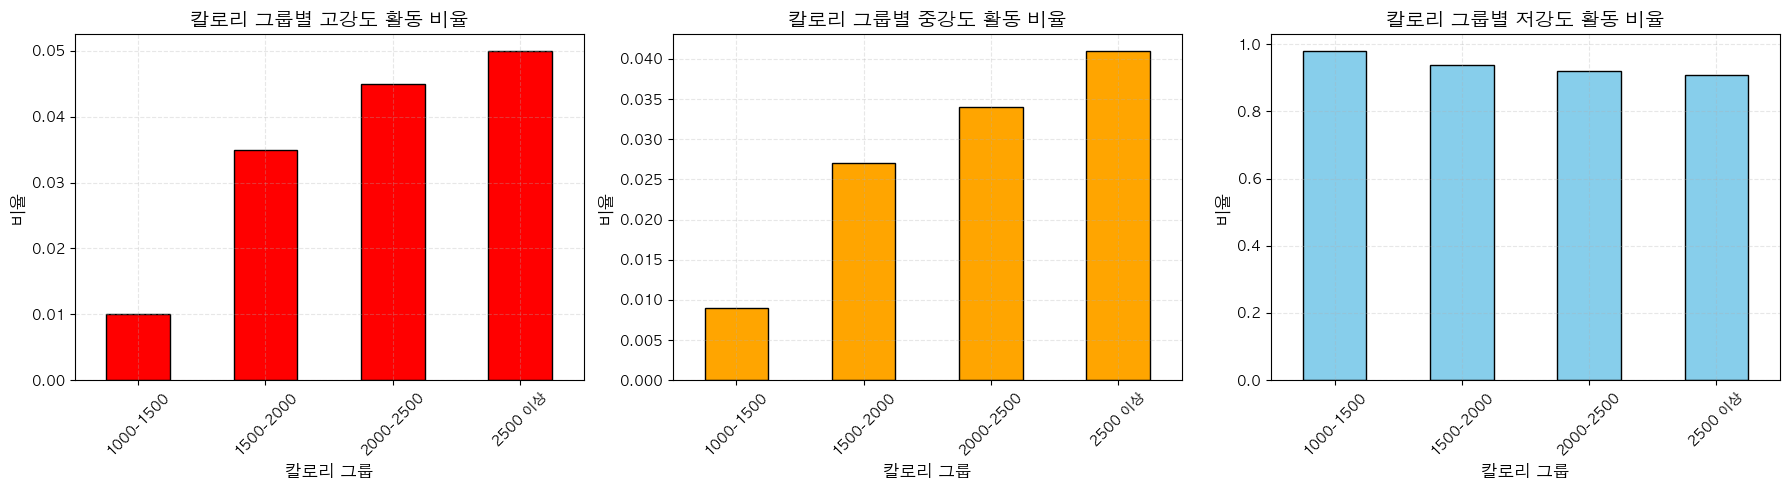

In [35]:
#활동 강도 비율 

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Very Active 비율
calorie_group_derived['VeryActiveRatio'].plot(kind='bar', ax=axes[0], color='red', edgecolor='black')
axes[0].set_title('칼로리 그룹별 고강도 활동 비율', fontsize=14, fontweight='bold')
axes[0].set_xlabel('칼로리 그룹', fontsize=12)
axes[0].set_ylabel('비율', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, linestyle='--')

# Moderate Active 비율
calorie_group_derived['ModerateActiveRatio'].plot(kind='bar', ax=axes[1], color='orange', edgecolor='black')
axes[1].set_title('칼로리 그룹별 중강도 활동 비율', fontsize=14, fontweight='bold')
axes[1].set_xlabel('칼로리 그룹', fontsize=12)
axes[1].set_ylabel('비율', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, linestyle='--')

# Light Active 비율
calorie_group_derived['LightActiveRatio'].plot(kind='bar', ax=axes[2], color='skyblue', edgecolor='black')
axes[2].set_title('칼로리 그룹별 저강도 활동 비율', fontsize=14, fontweight='bold')
axes[2].set_xlabel('칼로리 그룹', fontsize=12)
axes[2].set_ylabel('비율', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


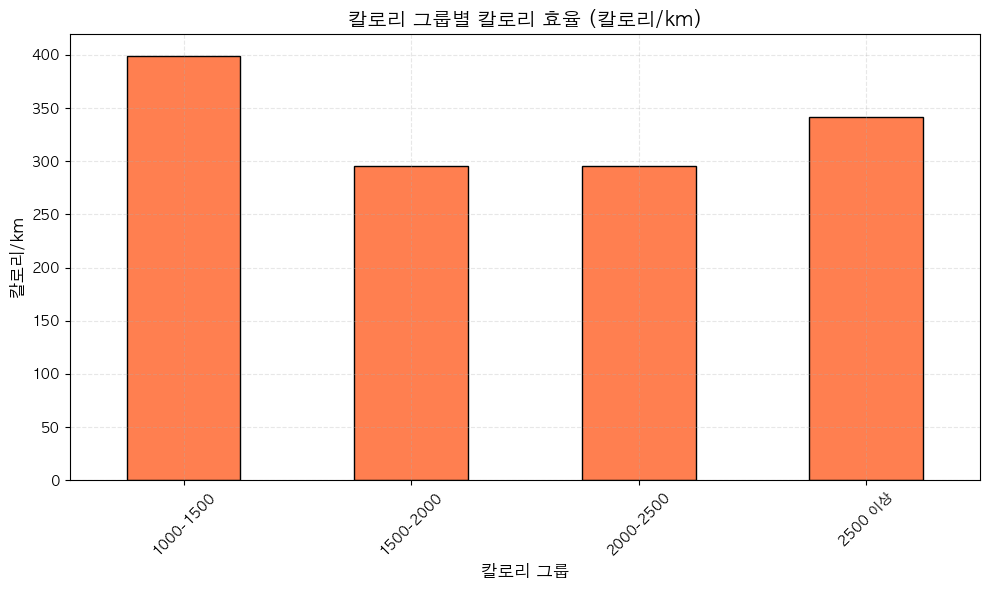

In [36]:
# 4. 칼로리 효율
plt.figure(figsize=(10, 6))
calorie_group_derived['CaloriesPerKm'].plot(kind='bar', color='coral', edgecolor='black')
plt.title('칼로리 그룹별 칼로리 효율 (칼로리/km)', fontsize=14, fontweight='bold')
plt.xlabel('칼로리 그룹', fontsize=12)
plt.ylabel('칼로리/km', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

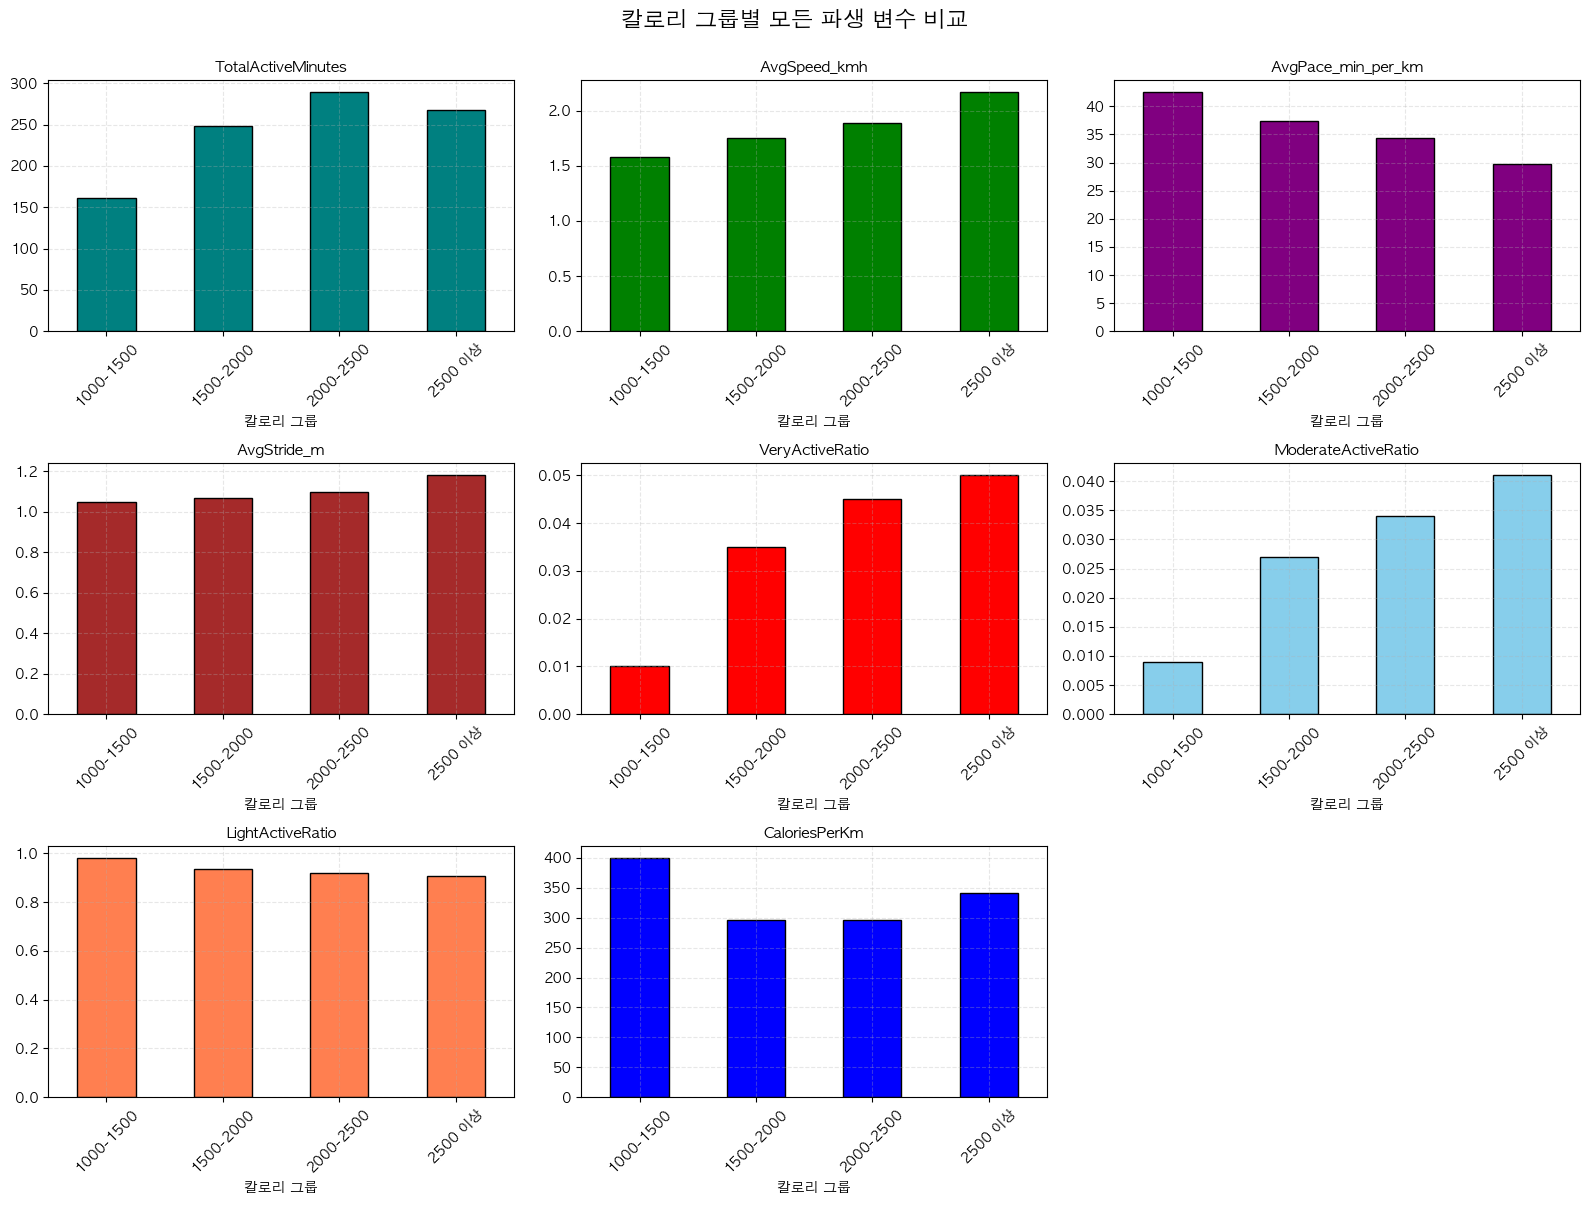

In [37]:
# 5. 모든 파생 변수 한번에 비교 (서브플롯)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

colors = ['teal', 'green', 'purple', 'brown', 'red', 'skyblue', 'coral','blue']

for idx, col in enumerate(derived_cols):
    calorie_group_derived[col].plot(kind='bar', ax=axes[idx], 
                                    color=colors[idx], edgecolor='black')
    axes[idx].set_title(f'{col}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('칼로리 그룹', fontsize=10)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3, linestyle='--')

# 남은 subplot 제거
for idx in range(len(derived_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('칼로리 그룹별 모든 파생 변수 비교', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

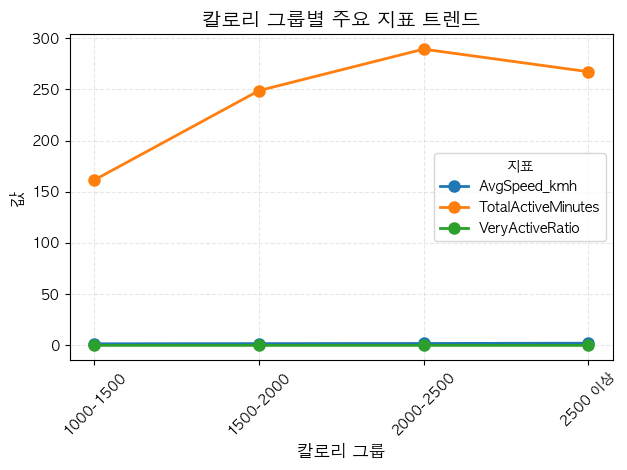

In [38]:
# 6. 라인 차트로 트렌드 확인
plt.figure(figsize=(12, 6))
calorie_group_derived[['AvgSpeed_kmh', 'TotalActiveMinutes', 'VeryActiveRatio']].plot(
    kind='line', marker='o', linewidth=2, markersize=8
)
plt.title('칼로리 그룹별 주요 지표 트렌드', fontsize=14, fontweight='bold')
plt.xlabel('칼로리 그룹', fontsize=12)
plt.ylabel('값', fontsize=12)
plt.legend(title='지표', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(range(len(calorie_group_derived)), calorie_group_derived.index, rotation=45)
plt.tight_layout()
plt.show()

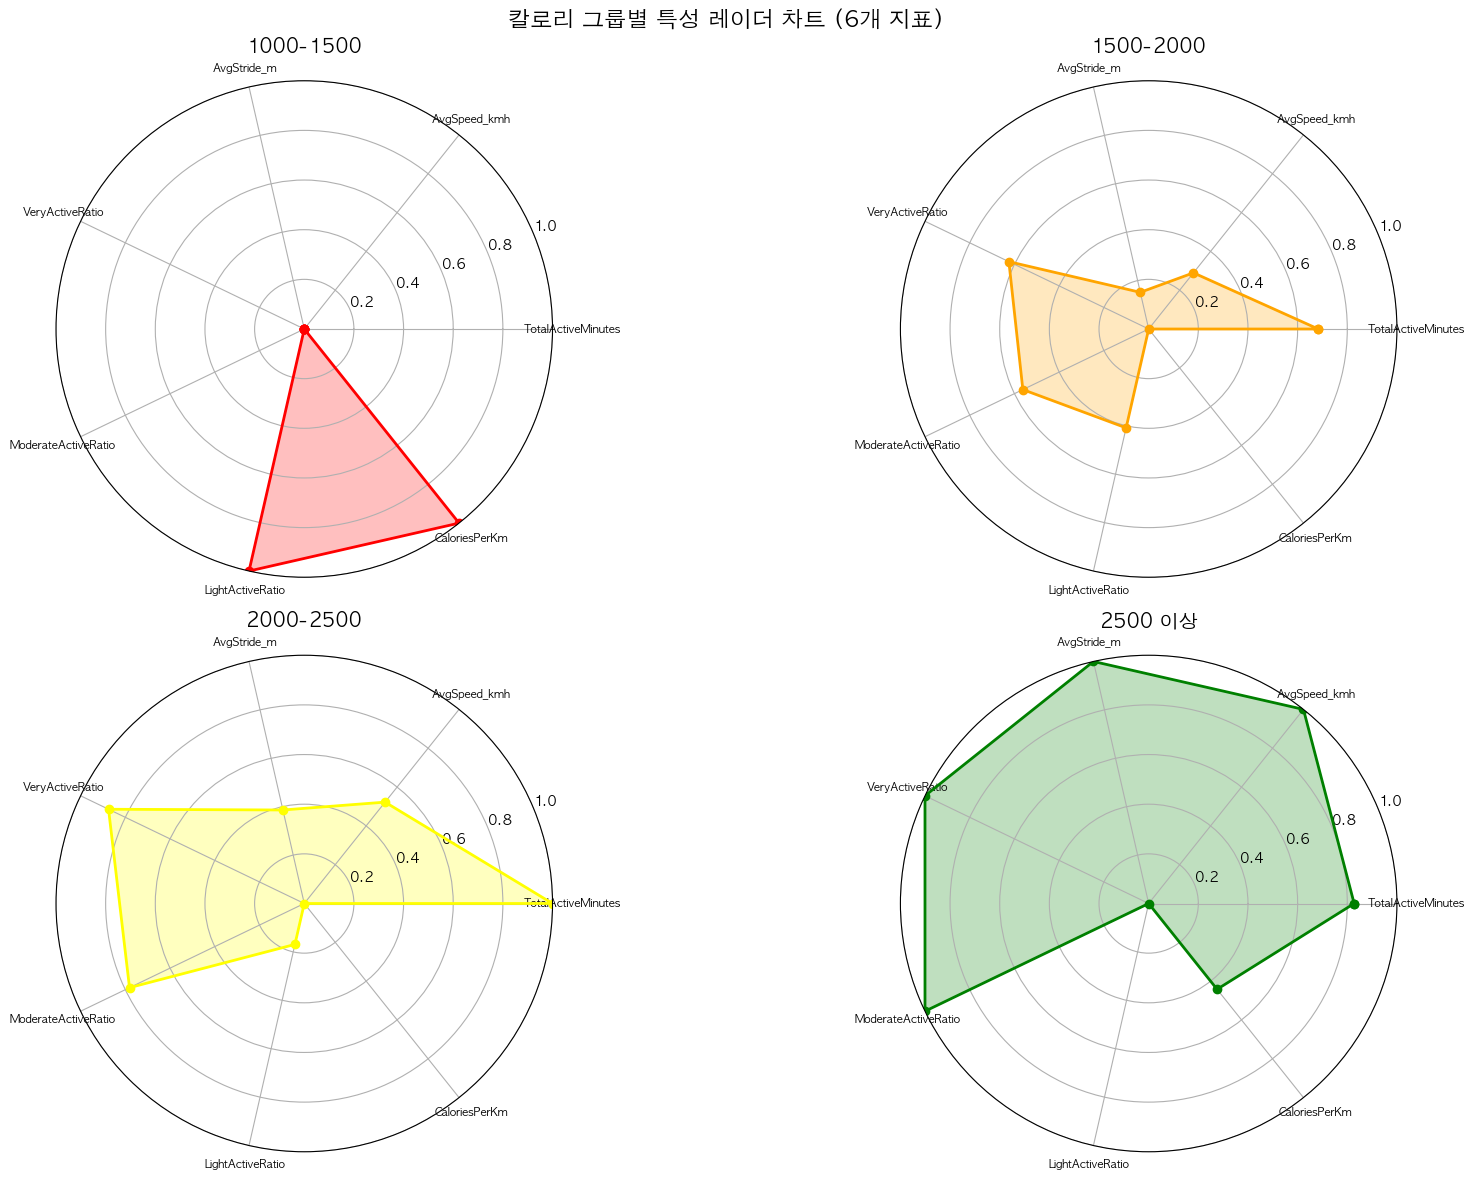

In [39]:
from sklearn.preprocessing import MinMaxScaler

# AvgPace_min_per_km 제외한 컬럼만 선택
radar_columns = ['TotalActiveMinutes', 'AvgSpeed_kmh', 'AvgStride_m', 
                 'VeryActiveRatio', 'ModerateActiveRatio', 'LightActiveRatio', 'CaloriesPerKm']

calorie_group_radar = calorie_group_derived[radar_columns]

# 정규화
scaler = MinMaxScaler()
calorie_group_derived_normalized = pd.DataFrame(
    scaler.fit_transform(calorie_group_radar),
    index=calorie_group_radar.index,
    columns=calorie_group_radar.columns
)

# 1. 레이더 차트 (각 칼로리 그룹의 특성을 한눈에)
import numpy as np
from math import pi

# 데이터 준비
categories = list(calorie_group_derived_normalized.columns)
N = len(categories)

# 각도 계산
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# 플롯 생성
fig, axes = plt.subplots(2, 2, figsize=(18, 12), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

colors = ['red', 'orange', 'yellow', 'green']  # 4개 그룹이므로 4개 색상

for idx, (group, color) in enumerate(zip(calorie_group_derived_normalized.index, colors)):
    ax = axes[idx]
    
    values = calorie_group_derived_normalized.loc[group].values.tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=group, color=color)
    ax.fill(angles, values, alpha=0.25, color=color)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=8)
    ax.set_ylim(0, 1)
    ax.set_title(f'{group}', size=14, fontweight='bold', pad=20)
    ax.grid(True)

# 6번째 subplot은 비우기 (5개 그룹만 있으므로)
#axes[5].axis('off')

plt.suptitle('칼로리 그룹별 특성 레이더 차트 (6개 지표)', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

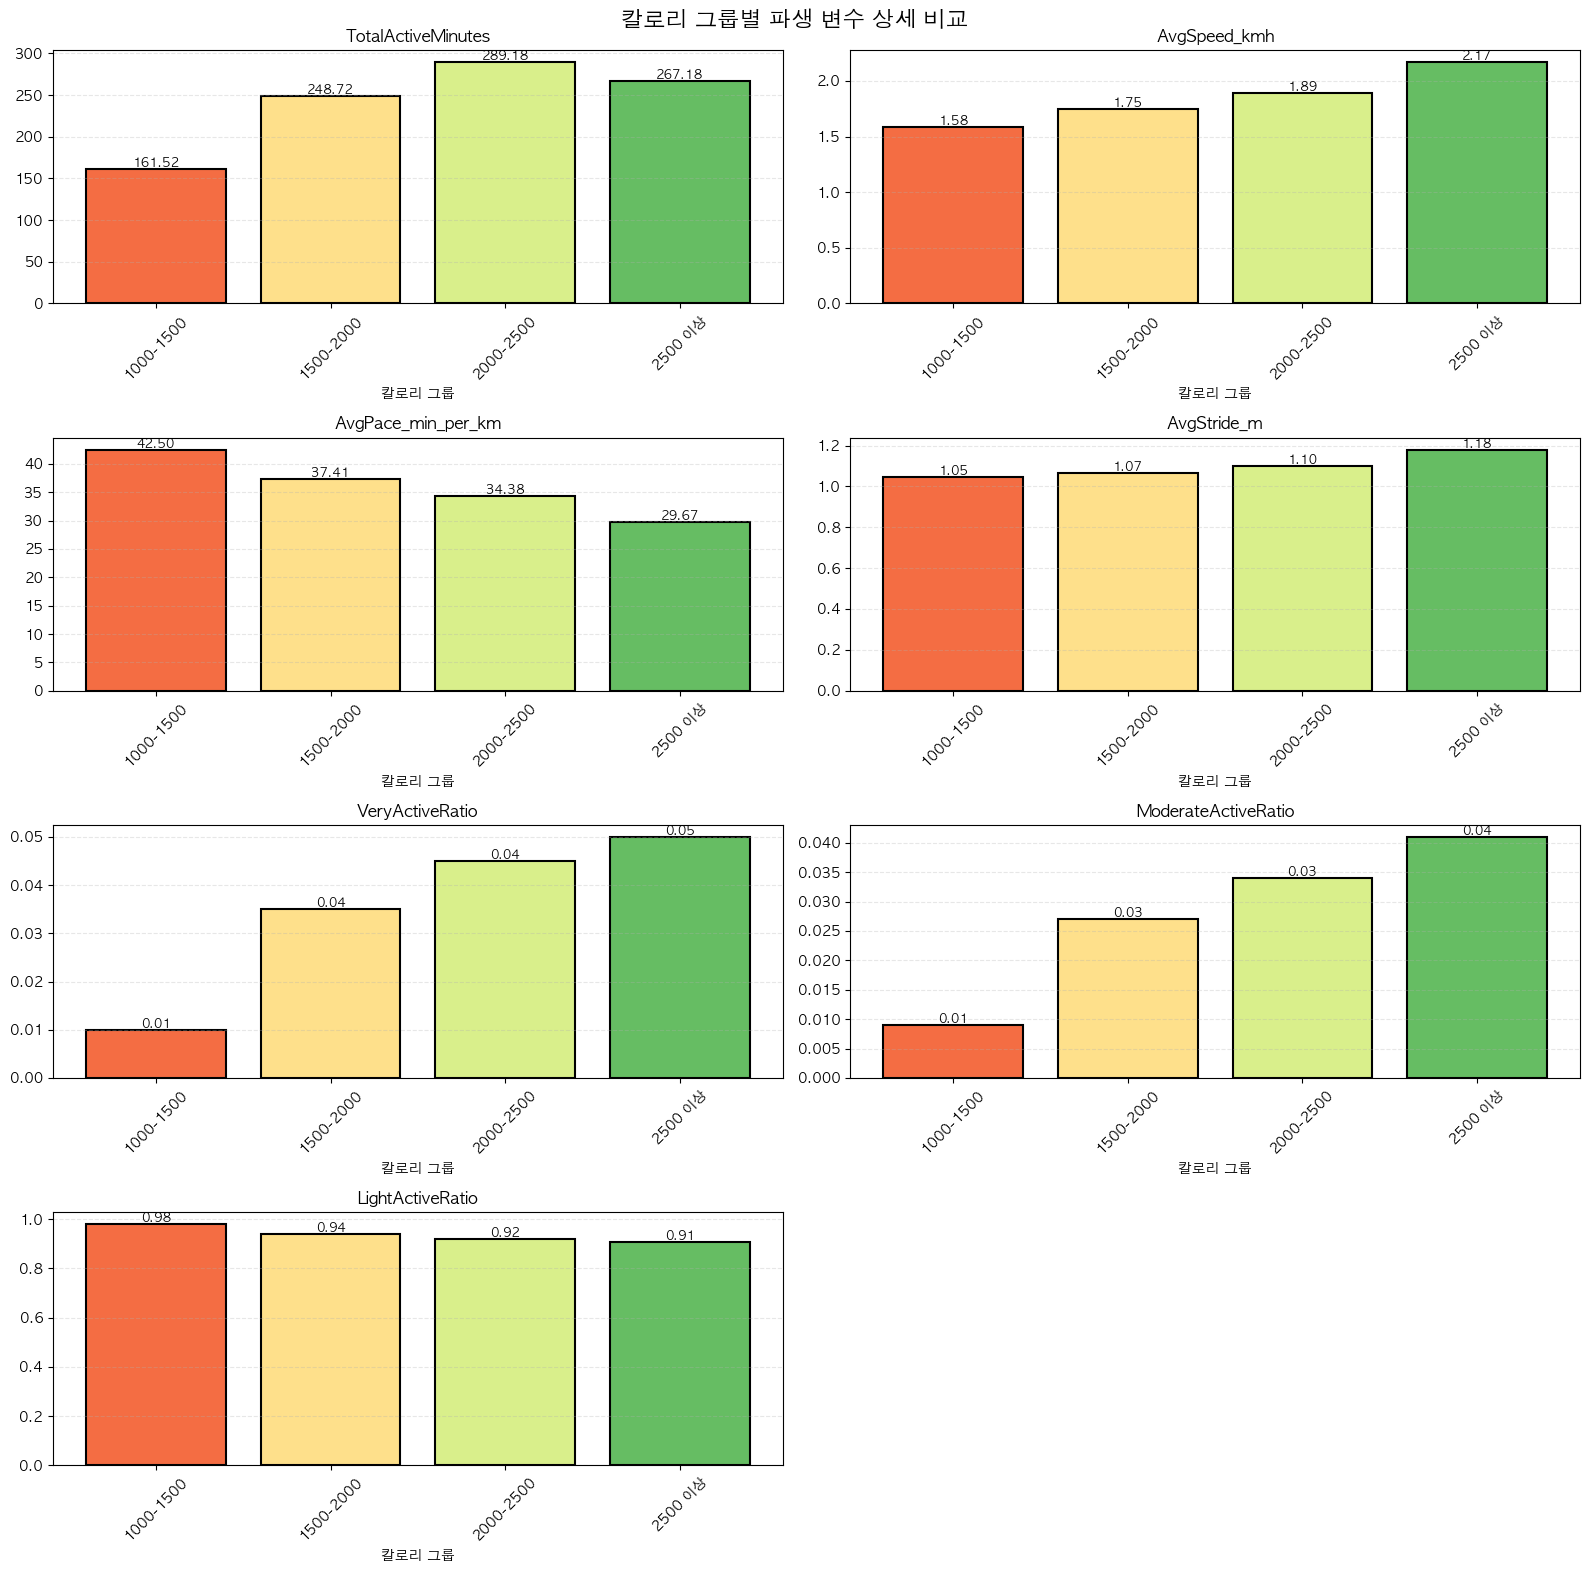

In [40]:
# 2. 변수별로 개별 막대 그래프 (비교하기 쉽게)
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.flatten()

colors_gradient = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(calorie_group_derived)))

for idx, col in enumerate(derived_cols):
    ax = axes[idx]
    bars = ax.bar(calorie_group_derived.index, 
                  calorie_group_derived[col], 
                  color=colors_gradient, 
                  edgecolor='black',
                  linewidth=1.5)
    
    # 값 표시
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_title(f'{col}', fontsize=12, fontweight='bold')
    ax.set_xlabel('칼로리 그룹', fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# 마지막 subplot 제거
fig.delaxes(axes[-1])

plt.suptitle('칼로리 그룹별 파생 변수 상세 비교', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

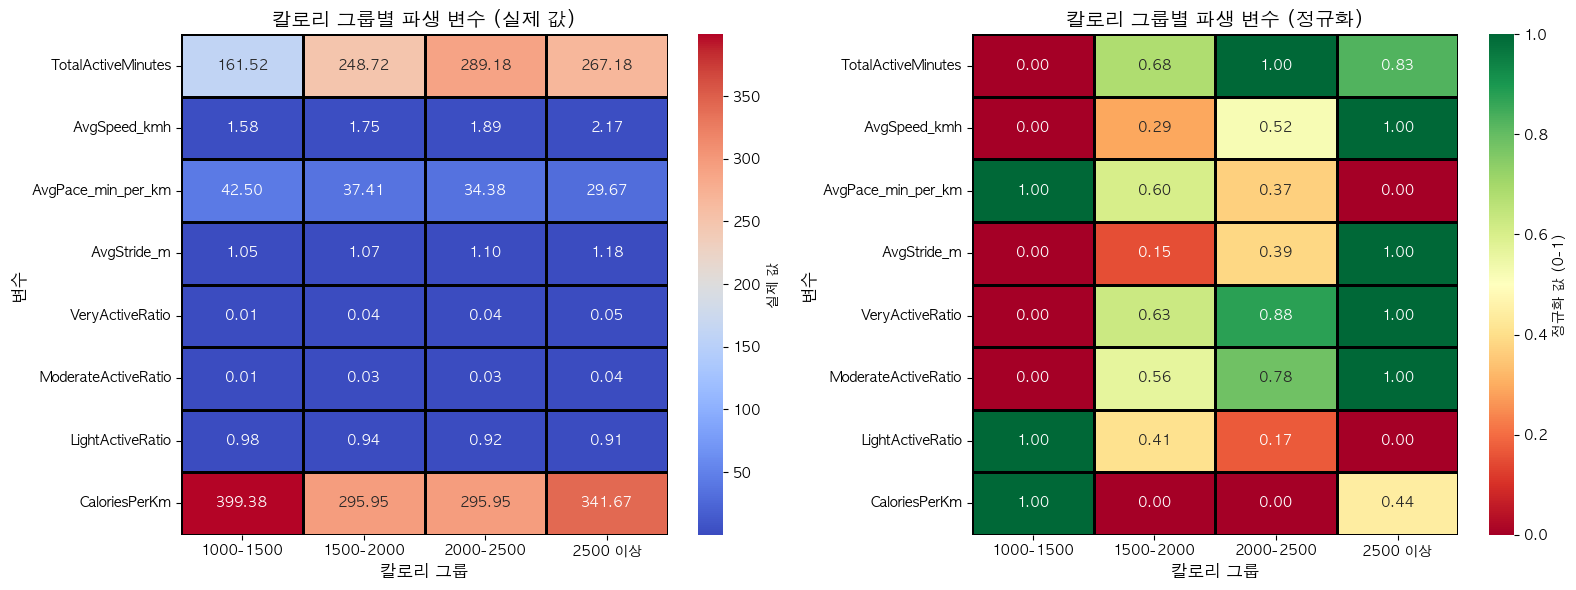

In [41]:
# 3. 히트맵 (더 명확한 색상)
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
calorie_group_derived_normalized = pd.DataFrame(
    scaler.fit_transform(calorie_group_derived),
    index=calorie_group_derived.index,
    columns=calorie_group_derived.columns
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#원본 히트맵
sns.heatmap(calorie_group_derived.T, annot=True, fmt='.2f', 
            cmap='coolwarm', cbar_kws={'label': '실제 값'}, 
            linewidths=1, linecolor='black', ax=axes[0])
axes[0].set_title('칼로리 그룹별 파생 변수 (실제 값)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('칼로리 그룹', fontsize=12)
axes[0].set_ylabel('변수', fontsize=12)

# 정규화된 값 히트맵
sns.heatmap(calorie_group_derived_normalized.T, annot=True, fmt='.2f', 
            cmap='RdYlGn', cbar_kws={'label': '정규화 값 (0-1)'}, 
            linewidths=1, linecolor='black', ax=axes[1],
            vmin=0, vmax=1)
axes[1].set_title('칼로리 그룹별 파생 변수 (정규화)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('칼로리 그룹', fontsize=12)
axes[1].set_ylabel('변수', fontsize=12)

plt.tight_layout()
plt.show()



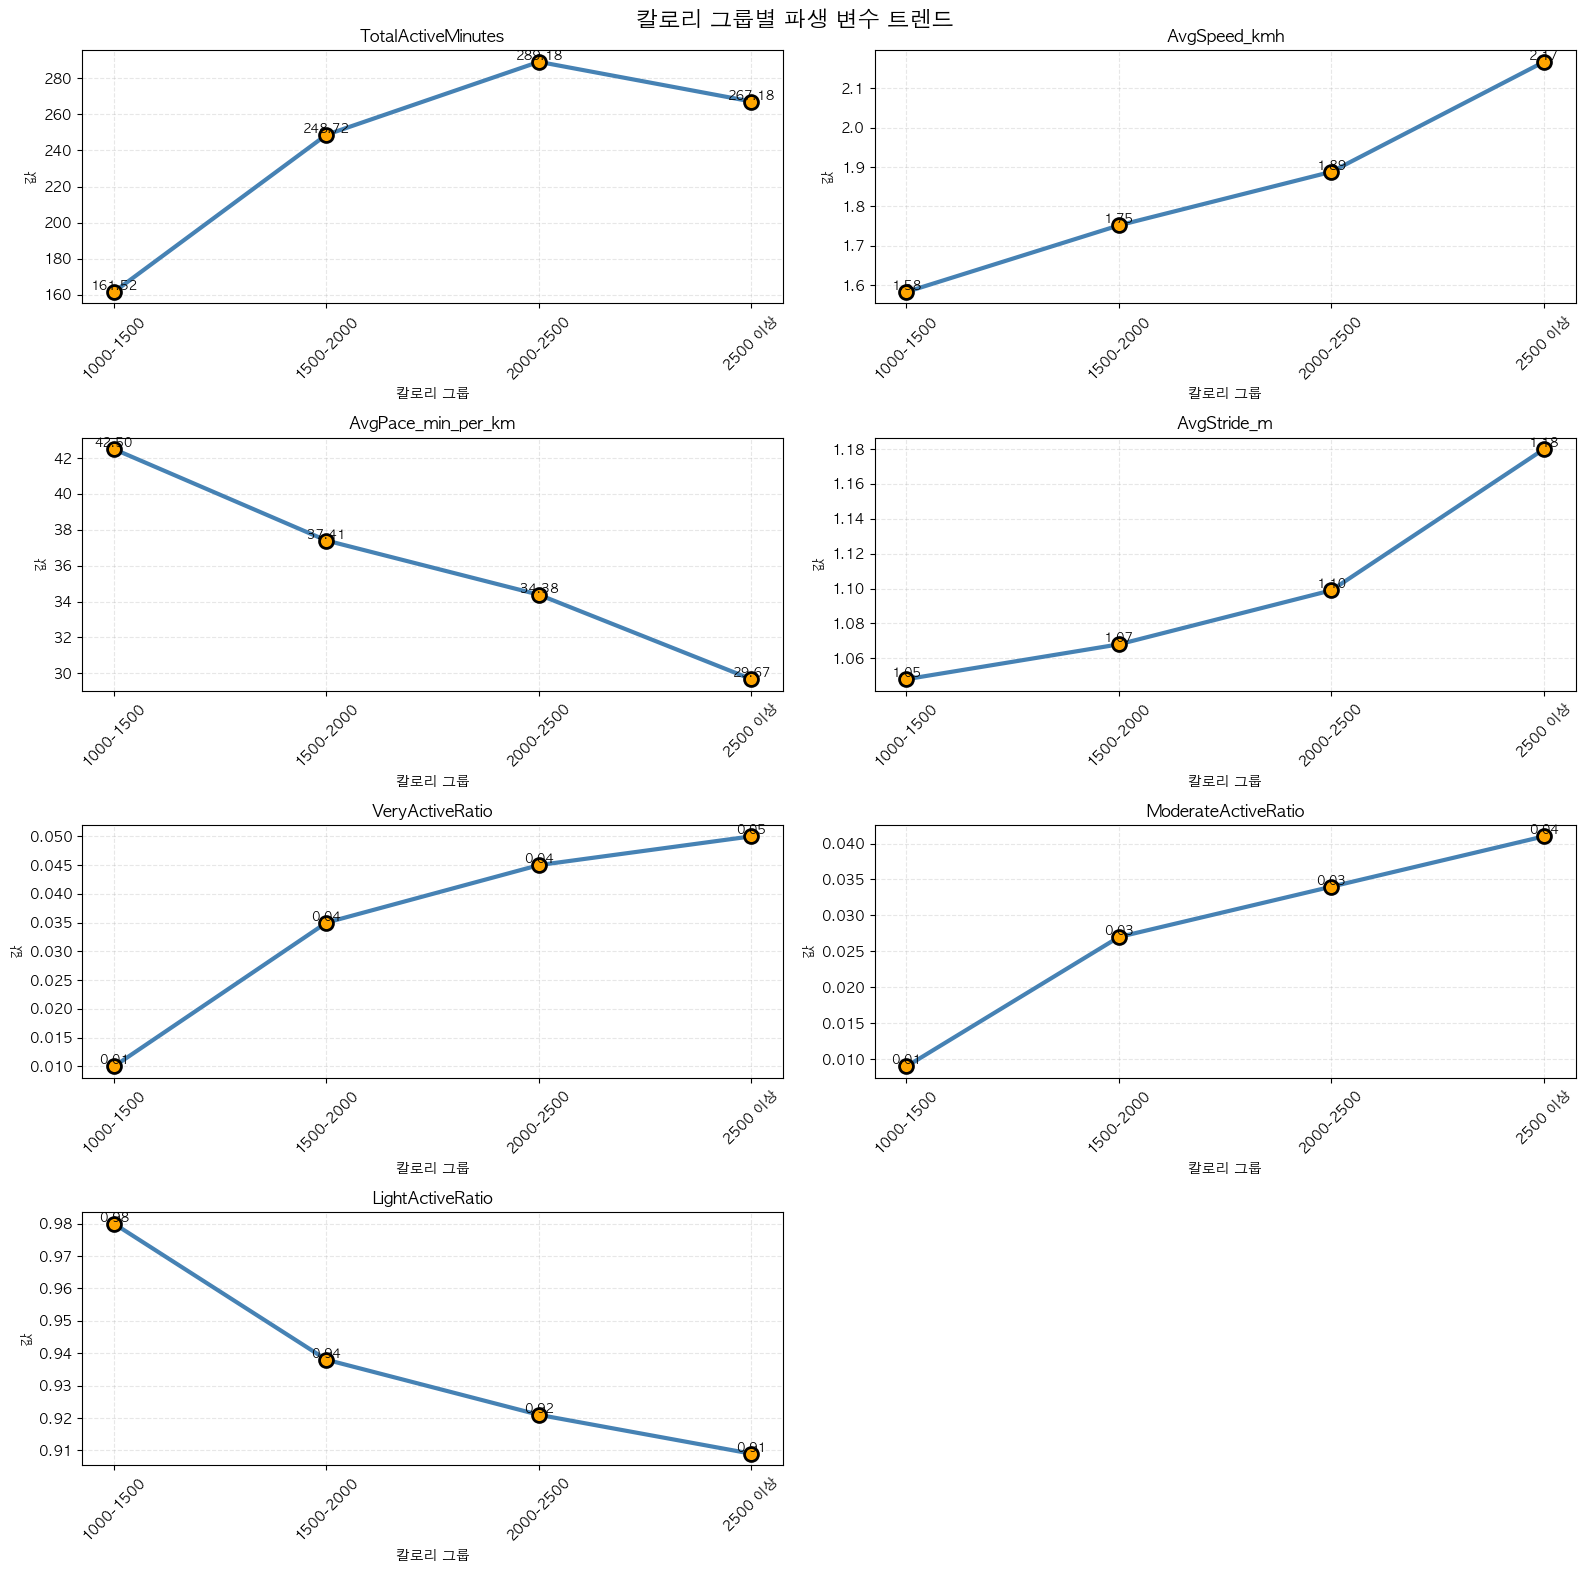

In [42]:
# 4. 라인 차트 (트렌드 파악)
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.flatten()

markers = ['o', 's', '^', 'D', 'v', '<', '>']

for idx, col in enumerate(derived_cols):
    ax = axes[idx]
    ax.plot(range(len(calorie_group_derived)), 
            calorie_group_derived[col], 
            marker='o', linewidth=3, markersize=10,
            color='steelblue', markerfacecolor='orange', 
            markeredgewidth=2, markeredgecolor='black')
    
    # 값 표시
    for i, (x, y) in enumerate(zip(range(len(calorie_group_derived)), 
                                    calorie_group_derived[col])):
        ax.text(x, y, f'{y:.2f}', ha='center', va='bottom', 
                fontsize=9, fontweight='bold')
    
    ax.set_title(f'{col}', fontsize=12, fontweight='bold')
    ax.set_xlabel('칼로리 그룹', fontsize=10)
    ax.set_ylabel('값', fontsize=10)
    ax.set_xticks(range(len(calorie_group_derived)))
    ax.set_xticklabels(calorie_group_derived.index, rotation=45)
    ax.grid(True, alpha=0.3, linestyle='--')

# 마지막 subplot 제거
fig.delaxes(axes[-1])

plt.suptitle('칼로리 그룹별 파생 변수 트렌드', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

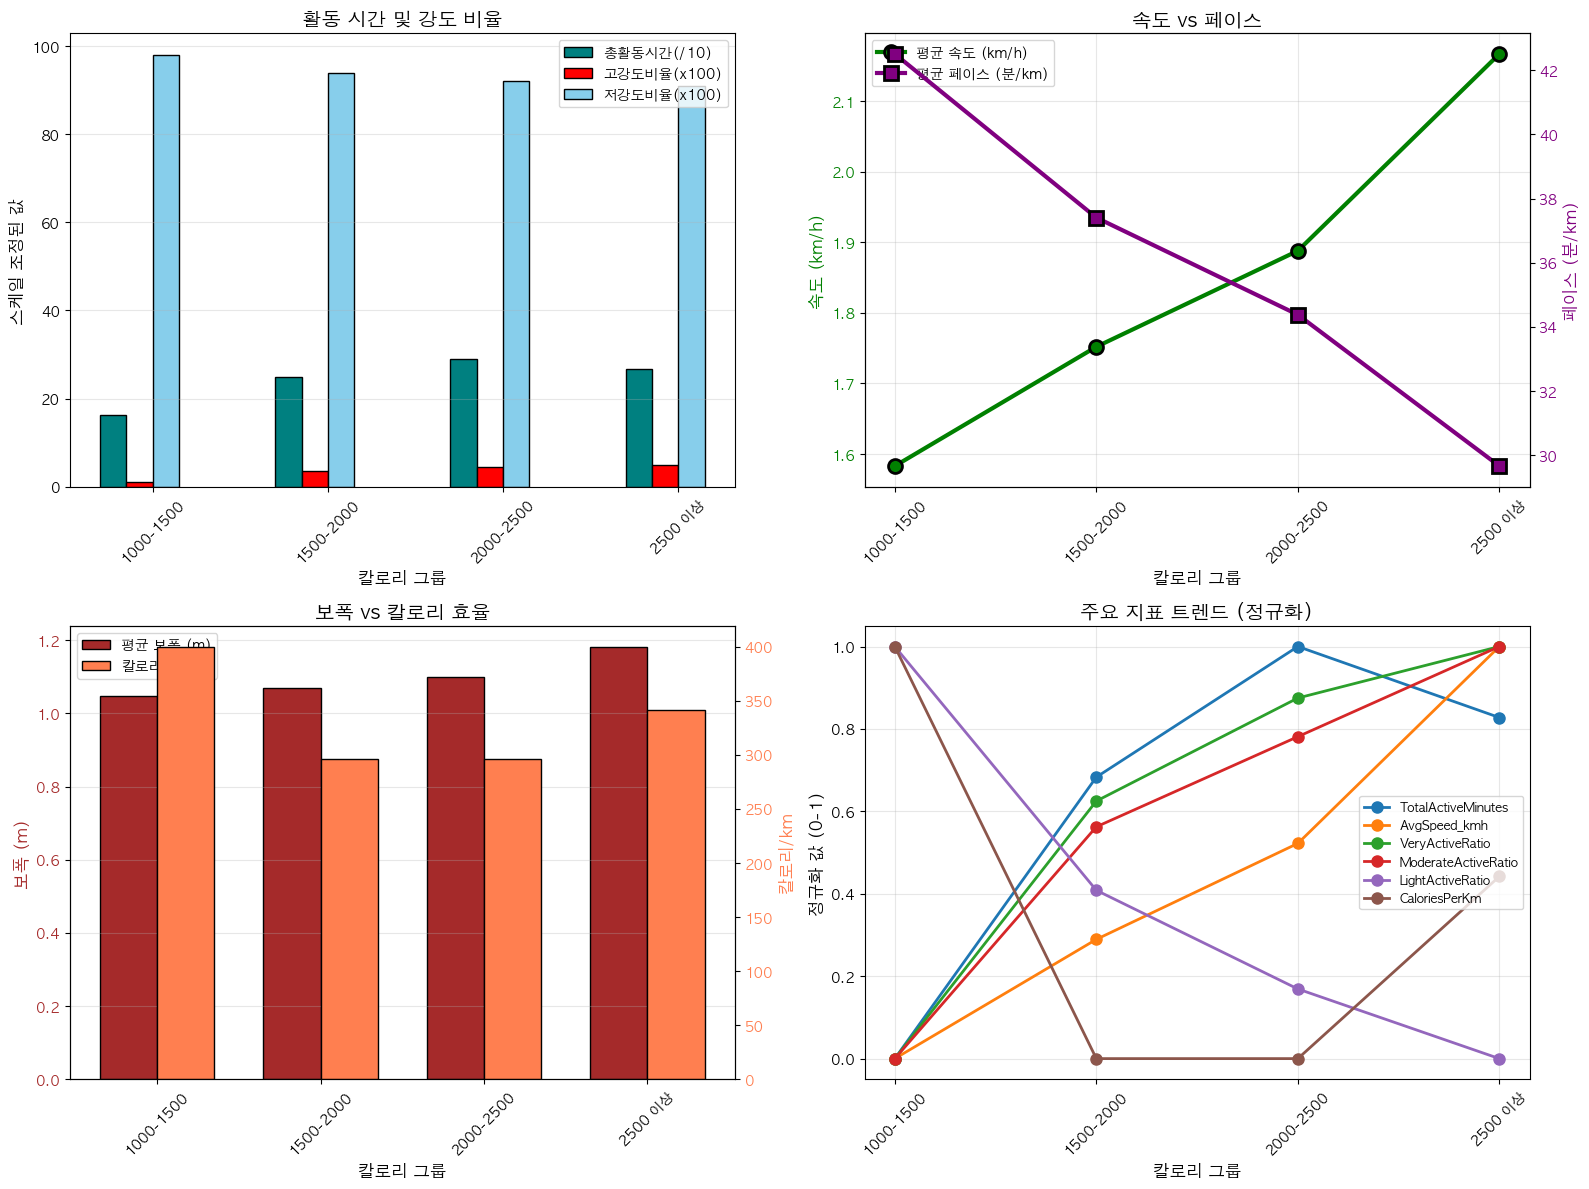

In [43]:
# 5. 그룹화된 비교 (관련 변수끼리)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 5-1. 활동 시간 & 비율
ax = axes[0, 0]
x = np.arange(len(calorie_group_derived))
width = 0.15

ax.bar(x - width*1.5, calorie_group_derived['TotalActiveMinutes']/10, 
       width, label='총활동시간(/10)', color='teal', edgecolor='black')
ax.bar(x - width*0.5, calorie_group_derived['VeryActiveRatio']*100, 
       width, label='고강도비율(x100)', color='red', edgecolor='black')
ax.bar(x + width*0.5, calorie_group_derived['LightActiveRatio']*100, 
       width, label='저강도비율(x100)', color='skyblue', edgecolor='black')

ax.set_xlabel('칼로리 그룹', fontsize=12)
ax.set_ylabel('스케일 조정된 값', fontsize=12)
ax.set_title('활동 시간 및 강도 비율', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(calorie_group_derived.index, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 5-2. 속도 & 페이스
ax = axes[0, 1]
ax2 = ax.twinx()

line1 = ax.plot(calorie_group_derived['AvgSpeed_kmh'], 
                marker='o', linewidth=3, markersize=10, 
                color='green', label='평균 속도 (km/h)', markeredgecolor='black', markeredgewidth=2)
line2 = ax2.plot(calorie_group_derived['AvgPace_min_per_km'], 
                 marker='s', linewidth=3, markersize=10, 
                 color='purple', label='평균 페이스 (분/km)', markeredgecolor='black', markeredgewidth=2)

ax.set_xlabel('칼로리 그룹', fontsize=12)
ax.set_ylabel('속도 (km/h)', fontsize=12, color='green')
ax2.set_ylabel('페이스 (분/km)', fontsize=12, color='purple')
ax.set_title('속도 vs 페이스', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(calorie_group_derived)))
ax.set_xticklabels(calorie_group_derived.index, rotation=45)
ax.tick_params(axis='y', labelcolor='green')
ax2.tick_params(axis='y', labelcolor='purple')
ax.grid(True, alpha=0.3)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper left')

# 5-3. 보폭 & 칼로리 효율
ax = axes[1, 0]
x = np.arange(len(calorie_group_derived))
width = 0.35

bars1 = ax.bar(x - width/2, calorie_group_derived['AvgStride_m'], 
               width, label='평균 보폭 (m)', color='brown', edgecolor='black')
ax2 = ax.twinx()
bars2 = ax2.bar(x + width/2, calorie_group_derived['CaloriesPerKm'], 
                width, label='칼로리/km', color='coral', edgecolor='black')

ax.set_xlabel('칼로리 그룹', fontsize=12)
ax.set_ylabel('보폭 (m)', fontsize=12, color='brown')
ax2.set_ylabel('칼로리/km', fontsize=12, color='coral')
ax.set_title('보폭 vs 칼로리 효율', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(calorie_group_derived.index, rotation=45)
ax.tick_params(axis='y', labelcolor='brown')
ax2.tick_params(axis='y', labelcolor='coral')
ax.grid(True, alpha=0.3, axis='y')

lines = [bars1, bars2]
labels = ['평균 보폭 (m)', '칼로리/km']
ax.legend(lines, labels, loc='upper left')

# 5-4. 종합 비교 (정규화)
ax = axes[1, 1]
calorie_group_derived_normalized[['TotalActiveMinutes', 'AvgSpeed_kmh', 
                                   'VeryActiveRatio','ModerateActiveRatio', 'LightActiveRatio', 'CaloriesPerKm']].plot(
    kind='line', marker='o', linewidth=2, markersize=8, ax=ax
)
ax.set_xlabel('칼로리 그룹', fontsize=12)
ax.set_ylabel('정규화 값 (0-1)', fontsize=12)
ax.set_title('주요 지표 트렌드 (정규화)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(calorie_group_derived)))
ax.set_xticklabels(calorie_group_derived.index, rotation=45)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

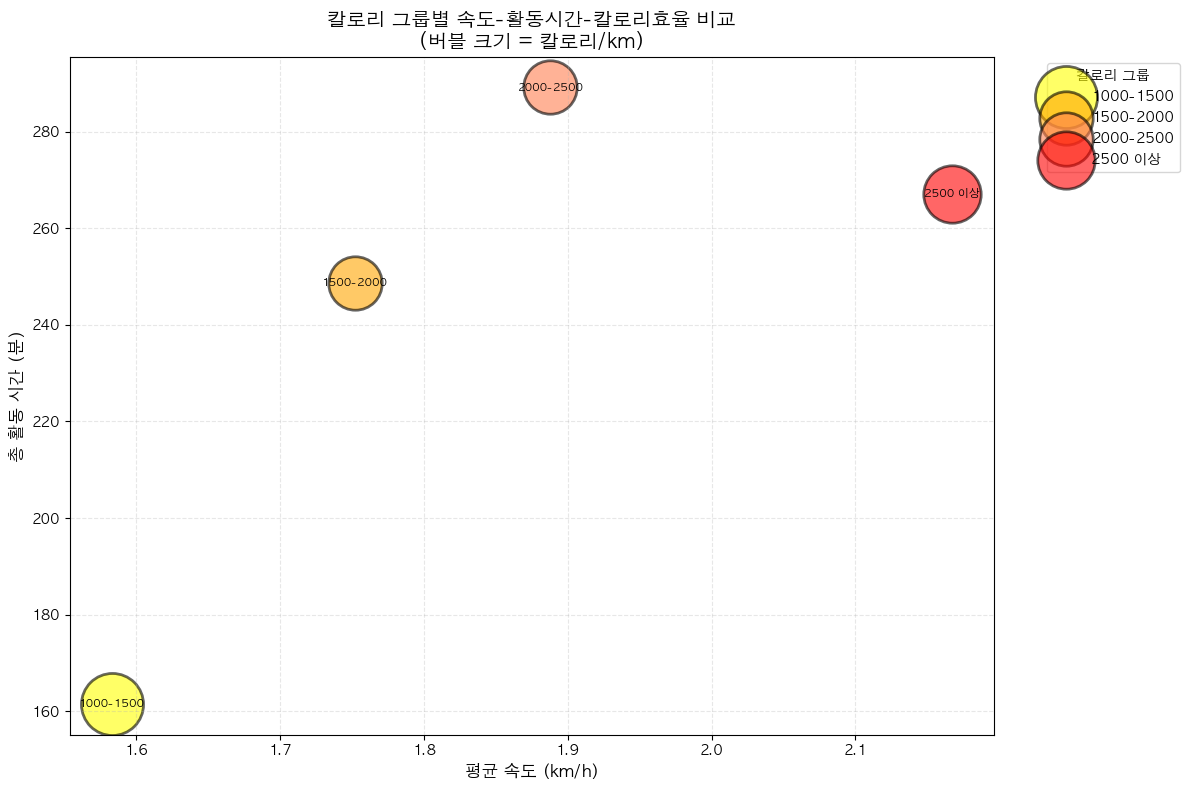

In [44]:
# 6. 버블 차트 (3개 변수 동시 비교)
plt.figure(figsize=(12, 8))

colors_map = {'500 이하': 'lightblue', '500-1000': 'lightgreen', 
              '1000-1500': 'yellow', '1500-2000': 'orange', 
              '2000-2500': 'coral', '2500 이상': 'red'}

for group in calorie_group_derived.index:
    plt.scatter(calorie_group_derived.loc[group, 'AvgSpeed_kmh'],
                calorie_group_derived.loc[group, 'TotalActiveMinutes'],
                s=calorie_group_derived.loc[group, 'CaloriesPerKm']*5,
                c=colors_map[group],
                alpha=0.6,
                edgecolors='black',
                linewidth=2,
                label=group)
    
    plt.text(calorie_group_derived.loc[group, 'AvgSpeed_kmh'],
             calorie_group_derived.loc[group, 'TotalActiveMinutes'],
             group, ha='center', va='center', fontsize=8, fontweight='bold')

plt.xlabel('평균 속도 (km/h)', fontsize=12)
plt.ylabel('총 활동 시간 (분)', fontsize=12)
plt.title('칼로리 그룹별 속도-활동시간-칼로리효율 비교\n(버블 크기 = 칼로리/km)', 
          fontsize=14, fontweight='bold')
plt.legend(title='칼로리 그룹', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

=== 사용자별 분석 ===

[상위 5명 - 평균 걸음수]
        Id   TotalSteps    Calories
1503960366 12163.761905 1874.000000
2022484408 10652.033333 2458.900000
8877689391 10042.083333 2686.666667
2347167796  9742.440000 2148.520000
7007744171  9703.866667 2508.933333

[하위 5명 - 평균 걸음수]
        Id  TotalSteps    Calories
6775888955 1967.000000 1032.000000
1927972279 3945.500000 2577.333333
1624580081 4587.378378 1433.675676
8253242879 4915.500000 1803.800000
1844505072 4936.360000 1836.920000

상위 5명 평균: 10461 steps/day
하위 5명 평균: 4070 steps/day
격차: 2.6배


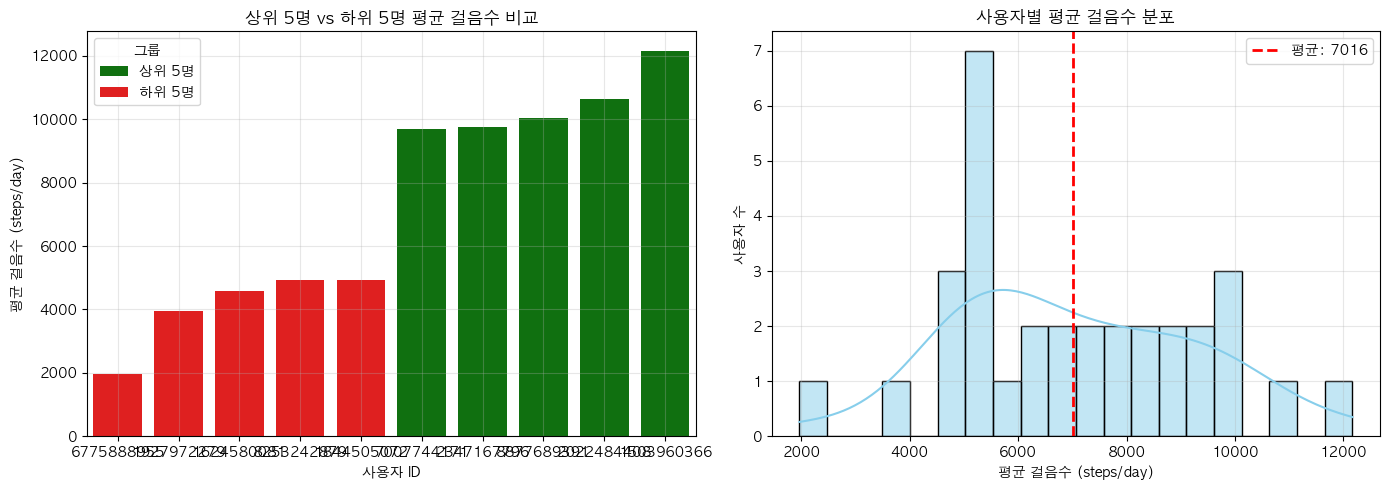

In [45]:
# actcp_d_clean으로 사용자별 분석
user_summary = (
    actcp_d_clean.groupby('Id').agg({
        'TotalSteps': 'mean',
        'Calories': 'mean',
        'TotalActiveMinutes': 'mean'
    })
    .reset_index()
    .sort_values('TotalSteps', ascending=True)   # 오름차순
)
top5 = user_summary.nlargest(5, 'TotalSteps').sort_values('TotalSteps', ascending=False)
bottom5 = user_summary.nsmallest(5, 'TotalSteps').sort_values('TotalSteps', ascending=True)


# 사용자별 분석
print("=== 사용자별 분석 ===")

# 상위/하위 사용자 정보 출력
print("\n[상위 5명 - 평균 걸음수]")
print(top5[['Id', 'TotalSteps', 'Calories']].to_string(index=False))

print("\n[하위 5명 - 평균 걸음수]")
print(bottom5[['Id', 'TotalSteps', 'Calories']].to_string(index=False))

# 격차 계산
print(f"\n상위 5명 평균: {top5['TotalSteps'].mean():.0f} steps/day")
print(f"하위 5명 평균: {bottom5['TotalSteps'].mean():.0f} steps/day")
print(f"격차: {top5['TotalSteps'].mean() / bottom5['TotalSteps'].mean():.1f}배")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) 상위 5명 vs 하위 5명 비교
combined = pd.concat([
    top5.assign(group='상위 5명'),
    bottom5.assign(group='하위 5명')
])
order_ids = combined.sort_values('TotalSteps')['Id']

sns.barplot(
    data=combined,
    x='Id',
    y='TotalSteps',
    hue='group',
    order=order_ids,
    ax=axes[0],
    palette=['green', 'red']
) 
axes[0].set_xlabel('사용자 ID')
axes[0].set_ylabel('평균 걸음수 (steps/day)')
axes[0].set_title('상위 5명 vs 하위 5명 평균 걸음수 비교', fontweight='bold')
axes[0].legend(title='그룹')
axes[0].grid(True, alpha=0.3)

# 2) 전체 사용자 분포
sns.histplot(data=user_summary, x='TotalSteps', bins=20, kde=True, 
             ax=axes[1], color='skyblue', edgecolor='black')
axes[1].axvline(user_summary['TotalSteps'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f"평균: {user_summary['TotalSteps'].mean():.0f}")
axes[1].set_xlabel('평균 걸음수 (steps/day)')
axes[1].set_ylabel('사용자 수')
axes[1].set_title('사용자별 평균 걸음수 분포', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== Steps vs Calories 상관관계 ===
상관계수: 0.328


/var/folders/wc/4jpr72gn34v7gndmn2_zk9680000gn/T/ipykernel_76500/2982021464.py:23: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(data=actcp_d_clean, x='TotalSteps', y='Calories',
/var/folders/wc/4jpr72gn34v7gndmn2_zk9680000gn/T/ipykernel_76500/2982021464.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


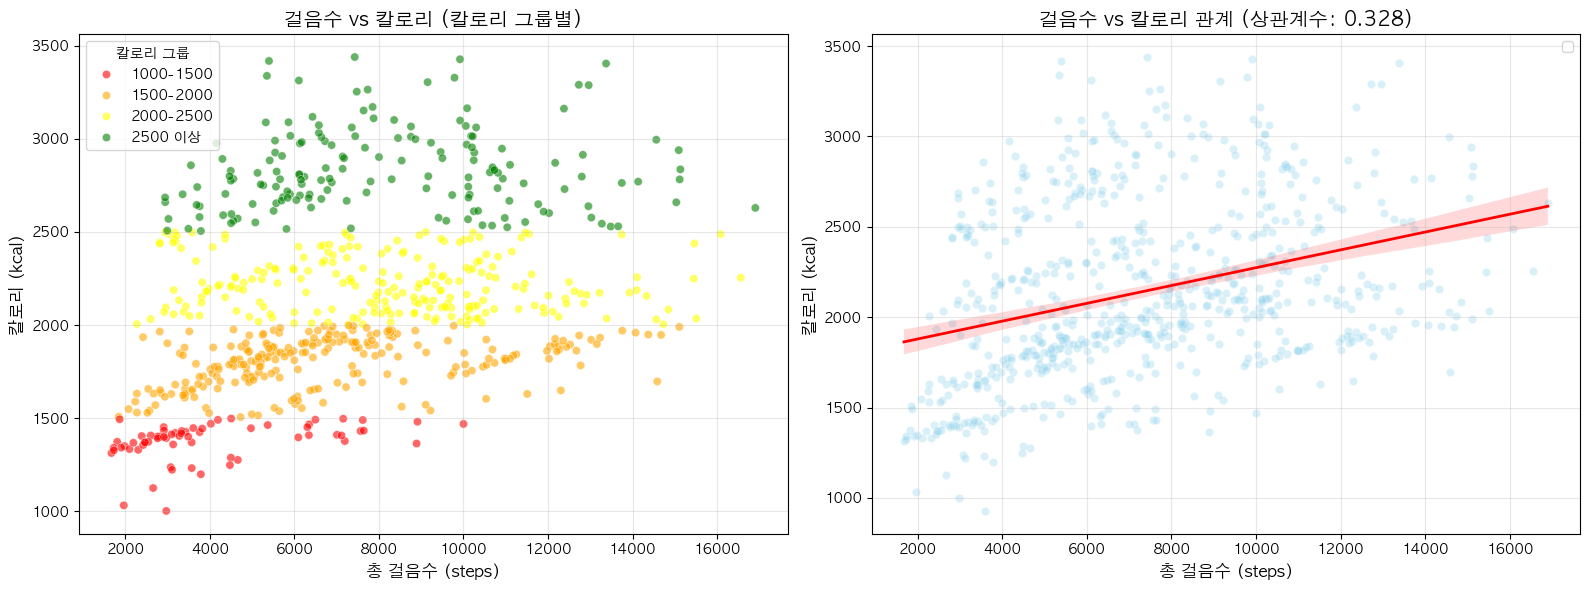

In [46]:
# Steps vs Calories 관계 분석 (정제된 데이터 사용)
print("\n=== Steps vs Calories 상관관계 ===")
correlation = actcp_d_clean['TotalSteps'].corr(actcp_d_clean['Calories'])
print(f"상관계수: {correlation:.3f}")

# 칼로리 그룹 생성 (500 미만 제외, 5000 초과도 제외)
actcp_d_clean = actcp_d_clean[
    (actcp_d_clean['Calories'] >= 500) & 
    (actcp_d_clean['Calories'] <= 5000)
].copy()

actcp_d_clean['CalorieGroup'] = pd.cut(
    actcp_d_clean['Calories'],
    bins=[1000, 1500, 2000, 2500, 5000],
    labels=['1000-1500', '1500-2000', '2000-2500', '2500 이상'],
    include_lowest=True
)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1) 칼로리 그룹별 산점도
sns.scatterplot(data=actcp_d_clean, x='TotalSteps', y='Calories', 
                hue='CalorieGroup', alpha=0.6, ax=axes[0],
                palette=['red', 'orange', 'yellow', 'green', 'blue'])
axes[0].set_xlabel('총 걸음수 (steps)', fontsize=12)
axes[0].set_ylabel('칼로리 (kcal)', fontsize=12)
axes[0].set_title('걸음수 vs 칼로리 (칼로리 그룹별)', fontsize=14, fontweight='bold')
axes[0].legend(title='칼로리 그룹', loc='upper left')
axes[0].grid(True, alpha=0.3)

# 2) 회귀선 포함 산점도
sns.scatterplot(data=actcp_d_clean, x='TotalSteps', y='Calories', 
                alpha=0.3, color='skyblue', ax=axes[1])
sns.regplot(data=actcp_d_clean, x='TotalSteps', y='Calories', 
            scatter=False, color='red', ax=axes[1], 
            line_kws={'linewidth': 2, 'label': f'회귀선 (r={correlation:.3f})'})
axes[1].set_xlabel('총 걸음수 (steps)', fontsize=12)
axes[1].set_ylabel('칼로리 (kcal)', fontsize=12)
axes[1].set_title(f'걸음수 vs 칼로리 관계 (상관계수: {correlation:.3f})', 
                 fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [50]:
# 칼로리 그룹 + 주중/주말별 비교
weekend_analysis = actcp_d_clean.groupby(['CalorieGroup', 'is_weekend']).agg({
    'Calories': 'mean',
    'TotalSteps': 'mean',
    'TotalActiveMinutes': 'mean'
})
weekend_analysis = weekend_analysis.reset_index().copy()

/var/folders/wc/4jpr72gn34v7gndmn2_zk9680000gn/T/ipykernel_76500/961013855.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekend_analysis = actcp_d_clean.groupby(['CalorieGroup', 'is_weekend']).agg({


In [51]:
print("\n=== 칼로리 그룹별 주중/주말 활동 비교 ===")
weekend_analysis


=== 칼로리 그룹별 주중/주말 활동 비교 ===


,CalorieGroup,is_weekend,Calories,TotalSteps,TotalActiveMinutes
0,1000-1500,False,1379.541667,4261.770833,162.791667
1,1000-1500,True,1369.294118,3486.705882,157.941176
2,1500-2000,False,1810.576687,6955.527607,251.889571
3,1500-2000,True,1784.000000,6430.623377,242.000000
4,2000-2500,False,2219.723529,8441.729412,292.311765
5,2000-2500,True,2218.983607,7590.229508,280.442623
6,2500 이상,False,2825.362832,8255.238938,271.654867
7,2500 이상,True,2845.301887,7990.320755,257.622642


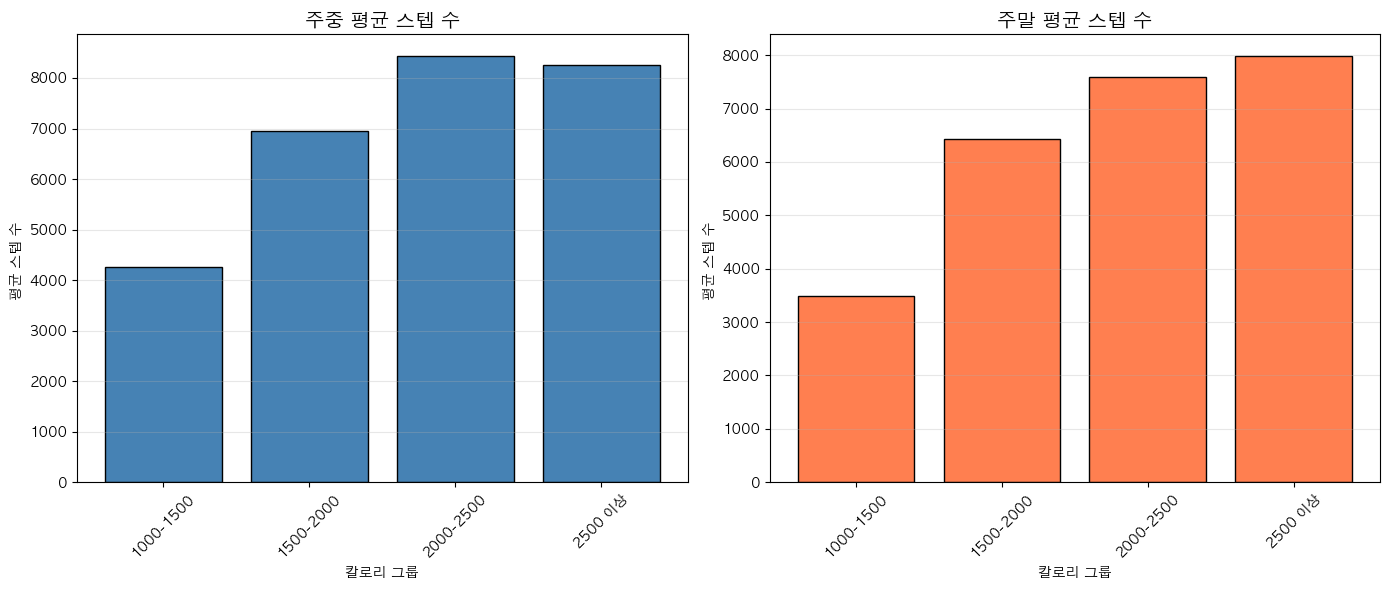

In [52]:
# 1. 칼로리 그룹별 주중/주말 스텝 수 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 데이터 준비
weekday_data = weekend_analysis[weekend_analysis['is_weekend'] == False].reset_index()
weekend_data = weekend_analysis[weekend_analysis['is_weekend'] == True].reset_index()

# 주중
axes[0].bar(range(len(weekday_data)), weekday_data['TotalSteps'], color='steelblue', edgecolor='black')
axes[0].set_xticks(range(len(weekday_data)))
axes[0].set_xticklabels(weekday_data['CalorieGroup'], rotation=45)
axes[0].set_title('주중 평균 스텝 수', fontsize=14, fontweight='bold')
axes[0].set_xlabel('칼로리 그룹')
axes[0].set_ylabel('평균 스텝 수 ')
axes[0].grid(axis='y', alpha=0.3)

# 주말
axes[1].bar(range(len(weekend_data)), weekend_data['TotalSteps'], color='coral', edgecolor='black')
axes[1].set_xticks(range(len(weekend_data)))
axes[1].set_xticklabels(weekend_data['CalorieGroup'], rotation=45)
axes[1].set_title('주말 평균 스텝 수', fontsize=14, fontweight='bold')
axes[1].set_xlabel('칼로리 그룹')
axes[1].set_ylabel('평균 스텝 수 ')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

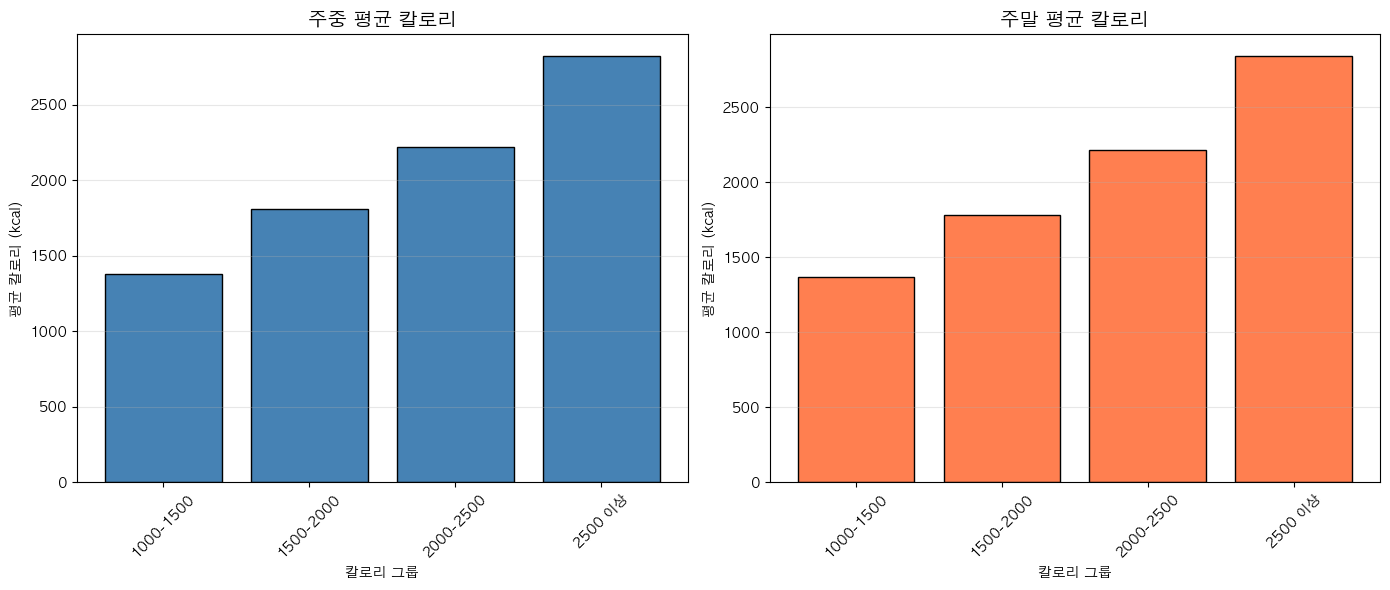

In [53]:
# 칼로리 그룹별 주중/주말 칼로리 소모
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 데이터 준비
weekday_data = weekend_analysis[weekend_analysis['is_weekend'] == False].reset_index()
weekend_data = weekend_analysis[weekend_analysis['is_weekend'] == True].reset_index()

# 주중
axes[0].bar(range(len(weekday_data)), weekday_data['Calories'], color='steelblue', edgecolor='black')
axes[0].set_xticks(range(len(weekday_data)))
axes[0].set_xticklabels(weekday_data['CalorieGroup'], rotation=45)
axes[0].set_title('주중 평균 칼로리', fontsize=14, fontweight='bold')
axes[0].set_xlabel('칼로리 그룹')
axes[0].set_ylabel('평균 칼로리 (kcal)')
axes[0].grid(axis='y', alpha=0.3)

# 주말
axes[1].bar(range(len(weekend_data)), weekend_data['Calories'], color='coral', edgecolor='black')
axes[1].set_xticks(range(len(weekend_data)))
axes[1].set_xticklabels(weekend_data['CalorieGroup'], rotation=45)
axes[1].set_title('주말 평균 칼로리', fontsize=14, fontweight='bold')
axes[1].set_xlabel('칼로리 그룹')
axes[1].set_ylabel('평균 칼로리 (kcal)')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

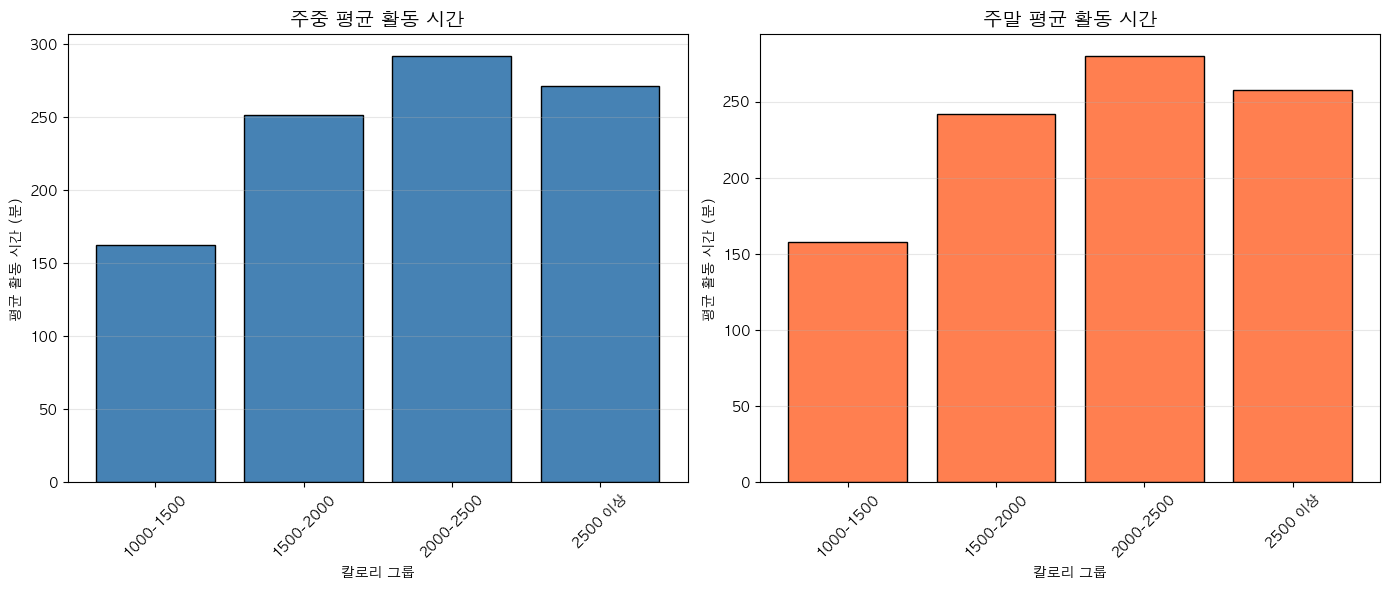

In [54]:
# 칼로리 그룹별 주중/주말 활동 시간 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 데이터 준비
weekday_data = weekend_analysis[weekend_analysis['is_weekend'] == False].reset_index()
weekend_data = weekend_analysis[weekend_analysis['is_weekend'] == True].reset_index()

# 주중
axes[0].bar(range(len(weekday_data)), weekday_data['TotalActiveMinutes'], color='steelblue', edgecolor='black')
axes[0].set_xticks(range(len(weekday_data)))
axes[0].set_xticklabels(weekday_data['CalorieGroup'], rotation=45)
axes[0].set_title('주중 평균 활동 시간', fontsize=14, fontweight='bold')
axes[0].set_xlabel('칼로리 그룹')
axes[0].set_ylabel('평균 활동 시간 (분)')
axes[0].grid(axis='y', alpha=0.3)

# 주말
axes[1].bar(range(len(weekend_data)), weekend_data['TotalActiveMinutes'], color='coral', edgecolor='black')
axes[1].set_xticks(range(len(weekend_data)))
axes[1].set_xticklabels(weekend_data['CalorieGroup'], rotation=45)
axes[1].set_title('주말 평균 활동 시간', fontsize=14, fontweight='bold')
axes[1].set_xlabel('칼로리 그룹')
axes[1].set_ylabel('평균 활동 시간 (분)')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [55]:
# 데이터 시작 날짜
start_date = actcp_d_clean['ActivityDate'].min()

# 시작일 기준 주차 생성
actcp_d_clean['week_from_start'] = (
    (actcp_d_clean['ActivityDate'] - start_date).dt.days // 7
) + 1



In [56]:
weekly_trend = actcp_d_clean.groupby('week_from_start').agg({
    'Calories': 'mean',
    'TotalSteps': 'mean',
    'TotalActiveMinutes': 'mean'
}).reset_index()
print("\n=== 주차별 평균 활동 추이 ===")
weekly_trend.round(2)



=== 주차별 평균 활동 추이 ===


,week_from_start,Calories,TotalSteps,TotalActiveMinutes
0,1,2701.80,5226.20,186.40
1,2,1993.00,6403.50,186.00
2,3,2097.97,7103.18,232.26
3,4,2165.41,7392.54,263.45
4,5,2132.57,7385.69,260.91
5,6,2065.16,7270.74,261.28
6,7,2202.97,7562.87,269.59
7,8,2169.98,7465.63,259.56
8,9,2087.39,6958.68,243.70


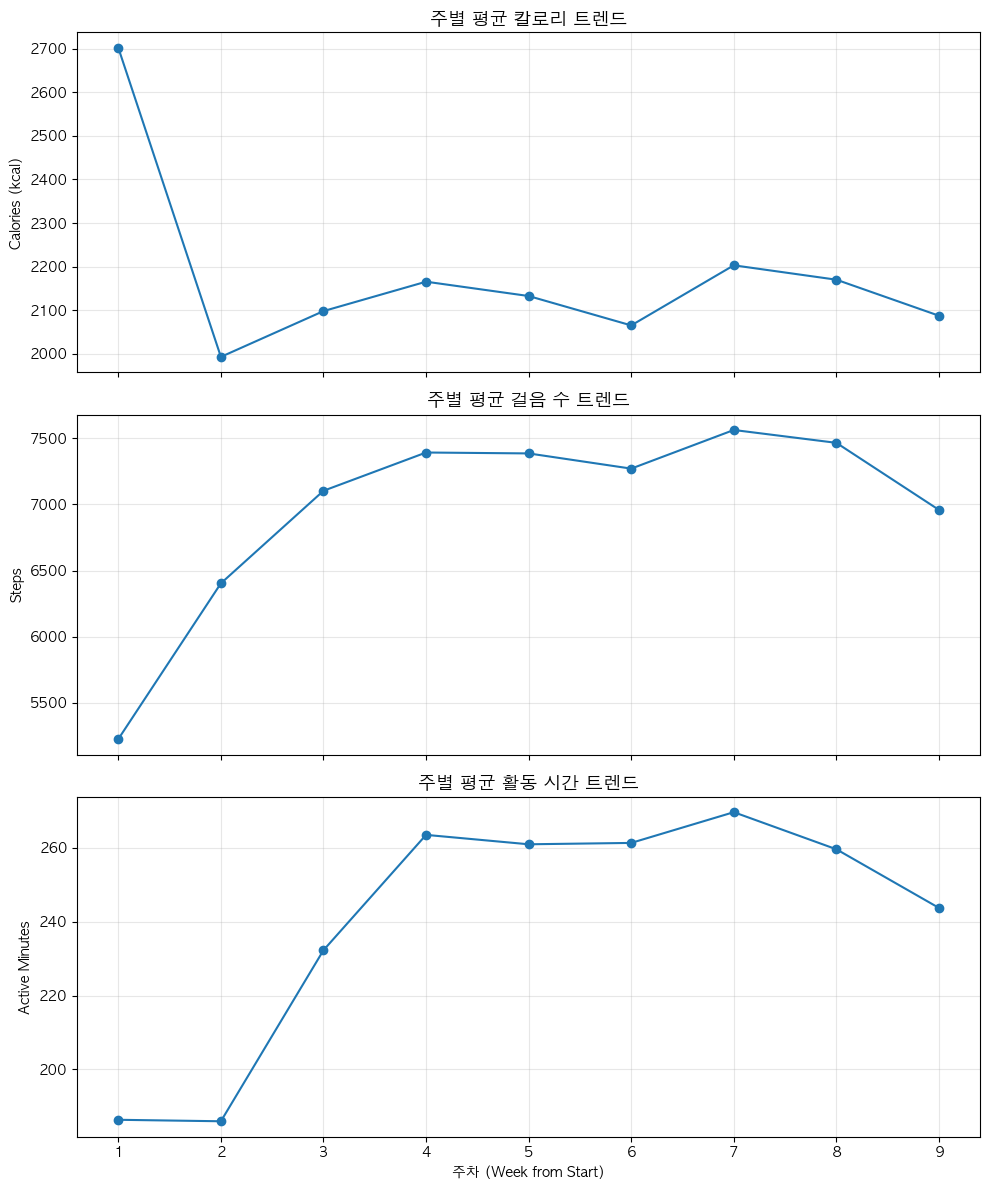

In [57]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# 1. Calories
axes[0].plot(
    weekly_trend['week_from_start'],
    weekly_trend['Calories'],
    marker='o'
)
axes[0].set_title('주별 평균 칼로리 트렌드', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Calories (kcal)')
axes[0].grid(alpha=0.3)

# 2. Total Steps
axes[1].plot(
    weekly_trend['week_from_start'],
    weekly_trend['TotalSteps'],
    marker='o'
)
axes[1].set_title('주별 평균 걸음 수 트렌드', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Steps')
axes[1].grid(alpha=0.3)

# 3. Total Active Minutes
axes[2].plot(
    weekly_trend['week_from_start'],
    weekly_trend['TotalActiveMinutes'],
    marker='o'
)
axes[2].set_title('주별 평균 활동 시간 트렌드', fontsize=13, fontweight='bold')
axes[2].set_xlabel('주차 (Week from Start)')
axes[2].set_ylabel('Active Minutes')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()



In [58]:

#연속 활동일(Streak) 기반 습관성 지표 계산 함수

def calculate_streak(user_dates):
    user_dates = pd.to_datetime(user_dates).dt.normalize().dropna().unique()
    user_dates = sorted(user_dates)

    if len(user_dates) == 0:
        return 0

    max_streak = 1
    current_streak = 1

    for i in range(1, len(user_dates)):
        if (user_dates[i] - user_dates[i-1]).days == 1:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 1

    return max_streak




In [64]:
import pandas as pd

# 0) 전처리: 날짜 정리 + 정렬 + (같은 날 중복 있으면 1개로)
tmp = actcp_d_clean.copy()
tmp["ActivityDate"] = pd.to_datetime(tmp["ActivityDate"], errors="coerce").dt.normalize()
tmp = tmp.dropna(subset=["ActivityDate", "CalorieGroup"])

# 같은 사람이 같은 날짜에 여러 행이 있을 수 있으면 제거(가장 첫 행 유지)
tmp = tmp.sort_values(["Id", "ActivityDate"]).drop_duplicates(["Id", "ActivityDate"], keep="first")

# 1) streak 계산을 위한 "끊김" 구간 만들기
# - 날짜가 하루씩 이어지지 않거나
# - CalorieGroup이 바뀌면
# 새 streak 시작
prev_date = tmp.groupby("Id")["ActivityDate"].shift(1)
prev_group = tmp.groupby("Id")["CalorieGroup"].shift(1)

is_new_block = ((tmp["ActivityDate"] - prev_date).dt.days != 1) | (tmp["CalorieGroup"] != prev_group)
tmp["block"] = is_new_block.groupby(tmp["Id"]).cumsum()

# 2) (Id, CalorieGroup, block) 별 길이 = 해당 그룹의 연속 길이
run_lengths = (
    tmp.groupby(["Id", "CalorieGroup", "block"], observed=True)
       .size()
       .reset_index(name="run_len")
)

# 3) (Id, CalorieGroup) 별 최대 연속 길이
max_streak_by_group = (
    run_lengths.groupby(["Id", "CalorieGroup"], observed=True)["run_len"]
              .max()
              .reset_index(name="MaxStreak_in_Group")
)

max_streak_by_group



,Id,CalorieGroup,MaxStreak_in_Group
0,1503960366,1500-2000,8
1,1503960366,2000-2500,2
2,1624580081,1000-1500,5
3,1624580081,1500-2000,2
4,1644430081,2000-2500,2
...,...,...,...
77,8792009665,2000-2500,1
78,8792009665,2500 이상,3
79,8877689391,1500-2000,1
80,8877689391,2000-2500,1


In [66]:
tmp2 = max_streak_by_group.copy()
tmp2["HabitUser"] = tmp2["MaxStreak_in_Group"] >= 7

habit_ratio_by_group = (
    tmp2.groupby("CalorieGroup",observed=True)["HabitUser"]
         .mean()
         .reset_index(name="HabitUserRatio")
)

habit_ratio_by_group



,CalorieGroup,HabitUserRatio
0,1000-1500,0.000000
1,1500-2000,0.136364
2,2000-2500,0.074074
3,2500 이상,0.090909


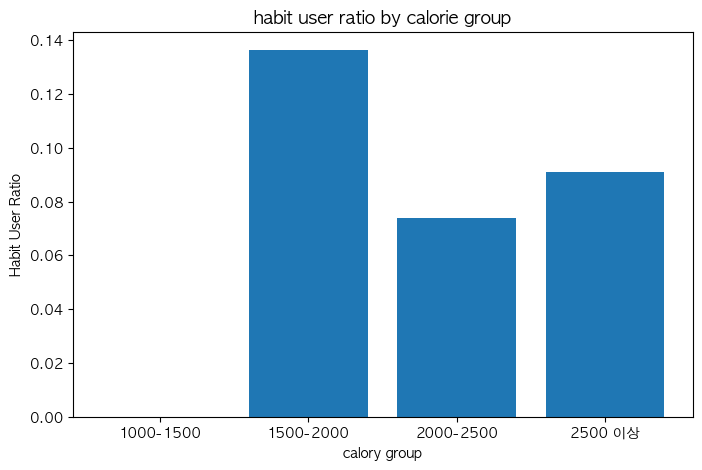

In [67]:
plt.rcParams['font.family'] = 'AppleGothic'
plt.figure(figsize=(8,5))
plt.bar(
    habit_ratio_by_group['CalorieGroup'],
    habit_ratio_by_group['HabitUserRatio']
)

plt.title('habit user ratio by calorie group', fontsize=13)
plt.xlabel('calory group')
plt.ylabel('Habit User Ratio')

plt.show()


In [103]:
#운동 강도 지표 분류 함수
def activity_profile(row):

    # Short & Intense
    if row['VeryActiveMinutes'] >= 15:
        return 'Short-Intense'

    # Long & Light
    if (row['TotalActiveMinutes'] >= 250) and (row['LightActiveRatio'] >= 0.90):
        return 'Long-Light'

    return 'Mixed'



In [104]:
actcp_d_clean['activity_profile'] = actcp_d_clean.apply(activity_profile, axis=1)



In [105]:
profile_summary = (
    actcp_d_clean
      .groupby('activity_profile')
      .agg(
          Days=('Id','count'),
          AvgCalories=('Calories','mean'),
          AvgActiveMinutes=('TotalActiveMinutes','mean'),
          AvgVeryActiveMin=('VeryActiveMinutes','mean'),
          AvgLightRatio=('LightActiveRatio','mean')
      )
      .sort_values('AvgCalories', ascending=False)
      .reset_index()
)
profile_summary


,activity_profile,Days,AvgCalories,AvgActiveMinutes,AvgVeryActiveMin,AvgLightRatio
0,Short-Intense,227,2263.625551,286.339207,29.828194,0.835792
1,Long-Light,203,2235.226601,326.334975,2.049261,0.978510
2,Mixed,273,1971.062271,183.919414,1.465201,0.970928


In [106]:
actcp_d_clean[['VeryActiveMinutes','TotalActiveMinutes','LightActiveRatio']].describe()


,VeryActiveMinutes,TotalActiveMinutes,LightActiveRatio
count,703.000000,703.000000,703.000000
mean,10.792319,258.115220,0.929481
std,14.930021,84.572477,0.079626
min,0.000000,56.000000,0.693694
25%,0.000000,191.500000,0.867912
50%,1.000000,258.000000,0.955556
75%,19.000000,324.000000,1.000000
max,59.000000,475.000000,1.000000


In [124]:

#활동 효율 계산
df = actcp_d_clean.copy()

# 1) 개인별 "저활동일" 기준: TotalActiveMinutes가 아주 낮은 날(예: 하위 20%)
q = df.groupby('Id')['TotalActiveMinutes'].transform(lambda s: s.quantile(0.2))
low_active = df[df['TotalActiveMinutes'] <= q]

# 2) 개인별 baseline calories 추정 (저활동일의 calories 중앙값)
baseline = low_active.groupby('Id')['Calories'].median().rename('BaselineCalories')

df = df.merge(baseline, on='Id', how='left')

# 3) 활동 칼로리(추정) = Total - Baseline (음수 방지)
df['ActiveCalories_est'] = (df['Calories'] - df['BaselineCalories']).clip(lower=0)

# 4) "활동 효율" = 활동칼로리 / 활동시간
df['ActiveCalPerMin'] = df['ActiveCalories_est'] / df['TotalActiveMinutes']

profile_eff = (
    df.groupby('activity_profile')
      .agg(
          Days=('Id','count'),
          AvgActiveCal=('ActiveCalories_est','mean'),
          AvgActiveMinutes=('TotalActiveMinutes','mean'),
          ActiveCalPerMin=('ActiveCalPerMin','mean')
      )
      .sort_values('ActiveCalPerMin', ascending=False)
      .reset_index()
)
print("\n=== 활동 프로파일별 활동 효율 ===")
profile_eff



=== 활동 프로파일별 활동 효율 ===


,activity_profile,Days,AvgActiveCal,AvgActiveMinutes,ActiveCalPerMin
0,Short-Intense,227,359.365639,286.339207,1.238204
1,Long-Light,203,318.098522,326.334975,0.957202
2,Mixed,273,121.091575,183.919414,0.599688


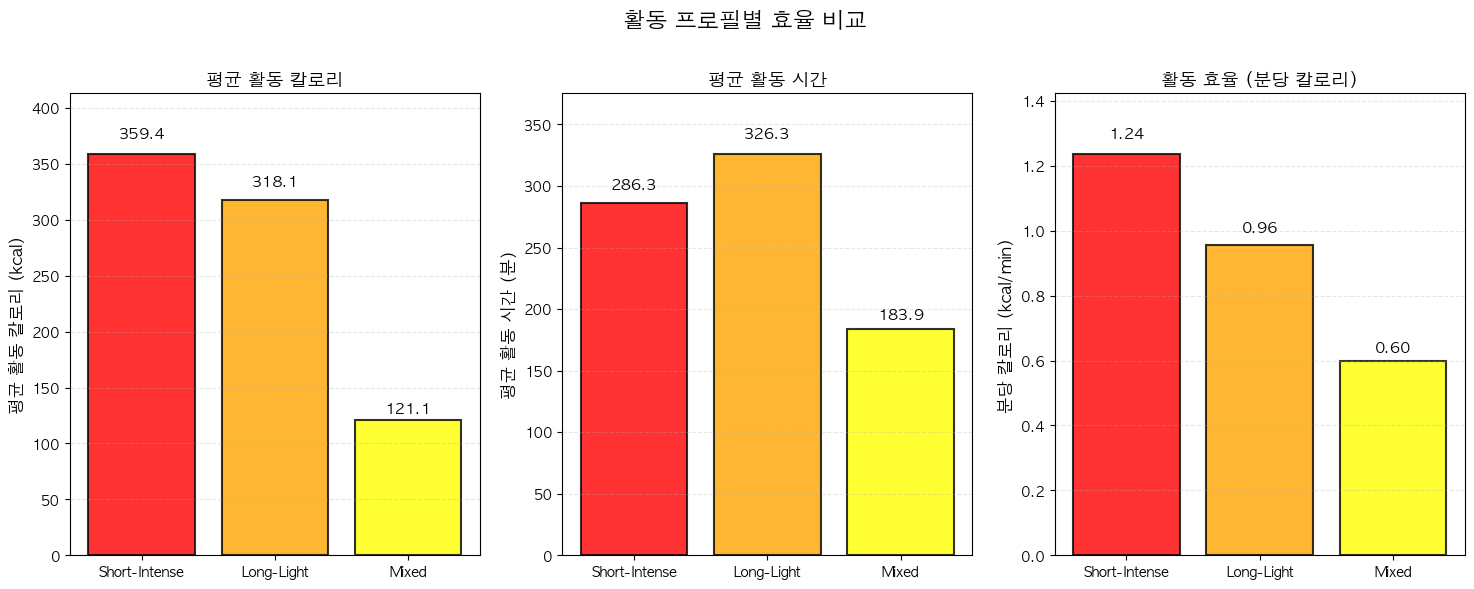

In [139]:
# 서브플롯 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('활동 프로필별 효율 비교', fontsize=16, fontweight='bold', y=1.02)

colors = ['red', 'orange', 'yellow']
metric_cols = ['AvgActiveCal', 'AvgActiveMinutes', 'ActiveCalPerMin']
metric_labels = ['평균 활동 칼로리 (kcal)', '평균 활동 시간 (분)', '분당 칼로리 (kcal/min)']
metric_titles = ['평균 활동 칼로리', '평균 활동 시간', '활동 효율 (분당 칼로리)']

# enumerate와 zip을 활용한 반복문
for idx, (col, label, title) in enumerate(zip(metric_cols, metric_labels, metric_titles)):
    ax = axes[idx]
    
    # 바 차트 그리기
    bars = ax.bar(
        profile_eff['activity_profile'],
        profile_eff[col],
        color=colors,
        edgecolor='black',
        linewidth=1.5,
        alpha=0.8
    )
    
    # 축 레이블 및 제목
    ax.set_ylabel(label, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim(0, profile_eff[col].max() * 1.15)
    
    # 값 표시
    for bar, val in zip(bars, profile_eff[col]):
        offset = val * 0.03  # 값에 비례한 오프셋
        format_str = '{:.2f}' if col == 'ActiveCalPerMin' else '{:.1f}'
        ax.text(bar.get_x() + bar.get_width()/2., val + offset,
                format_str.format(val),
                ha='center', va='bottom', fontsize=11, fontweight='bold')

In [108]:
#수면 패턴 분석 
sleep = pd.read_csv(
    "/Users/jisoyun/Desktop/sparta_python/Healthcare/sparta_15/data/sleepDay_merged 45.csv"
)
sleep['Id'] = sleep['Id'].astype(str)
sleep.head()


,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,4/12/2016 12:00:00 AM,1,327,346
1,1503960366,4/13/2016 12:00:00 AM,2,384,407
2,1503960366,4/15/2016 12:00:00 AM,1,412,442
3,1503960366,4/16/2016 12:00:00 AM,2,340,367
4,1503960366,4/17/2016 12:00:00 AM,1,700,712


In [109]:
sleep['ActivityDate'] = pd.to_datetime(sleep['SleepDay']).dt.normalize()


/var/folders/wc/4jpr72gn34v7gndmn2_zk9680000gn/T/ipykernel_91751/4123580256.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sleep['ActivityDate'] = pd.to_datetime(sleep['SleepDay']).dt.normalize()


In [110]:
actcp_d_clean['ActivityDate'] = pd.to_datetime(
    actcp_d_clean['ActivityDate']
).dt.normalize()

act_sleep = actcp_d_clean.merge(
    sleep[['Id', 'ActivityDate', 'TotalMinutesAsleep', 'TotalTimeInBed']],
    on=['Id', 'ActivityDate'],
    how='inner'
)


In [111]:
act_sleep.head()


,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,VeryActiveMinutes,...,AvgPace_min_per_km,AvgStride_m,VeryActiveRatio,LightActiveRatio,CaloriesPerKm,ModerateActiveRatio,week_from_start,activity_profile,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,2016-04-12,13386,8.64,8.64,0.0,1.88,0.55,6.19,25,...,26.968716,1.038772,0.066667,0.898667,146.350234,0.034667,5,Short-Intense,327,346
1,1503960366,2016-04-13,10735,6.97,6.97,0.0,1.57,0.69,4.71,21,...,22.911652,1.044900,0.081712,0.844358,160.203263,0.073930,5,Short-Intense,384,407
2,1503960366,2016-04-15,9762,6.28,6.28,0.0,2.14,1.26,2.83,29,...,26.912041,1.035341,0.106618,0.768382,172.652617,0.125000,5,Short-Intense,412,442
3,1503960366,2016-04-16,12669,8.16,8.16,0.0,2.71,0.41,5.04,36,...,20.332013,1.036546,0.134831,0.827715,141.867195,0.037453,6,Short-Intense,340,367
4,1503960366,2016-04-17,9705,6.48,6.48,0.0,3.19,0.78,2.51,38,...,21.286796,1.074601,0.171171,0.738739,165.691821,0.090090,6,Short-Intense,700,712


In [112]:
act_sleep.groupby('activity_profile')['TotalMinutesAsleep'].mean()


activity_profile
Long-Light       456.578125
Mixed            460.080460
Short-Intense    401.421053
Name: TotalMinutesAsleep, dtype: float64

In [113]:
act_sleep[['TotalMinutesAsleep','CaloriesPerKm']].corr()


,TotalMinutesAsleep,CaloriesPerKm
TotalMinutesAsleep,1.000000,0.137525
CaloriesPerKm,0.137525,1.000000


In [125]:
# 활동 프로필 × 칼로리 그룹 교차표
profile_cal_group = (
    actcp_d_clean
    .groupby(['activity_profile', 'CalorieGroup'])
    .size()
    .reset_index(name='Days')
)

# 활동 프로필 내 비율 계산
profile_cal_group['Ratio'] = (
    profile_cal_group['Days'] /
    profile_cal_group.groupby('activity_profile')['Days'].transform('sum')
)

print("\n=== 활동 프로필별 칼로리 그룹 분포 ===")
profile_cal_group



=== 활동 프로필별 칼로리 그룹 분포 ===


,activity_profile,CalorieGroup,Days,Ratio
0,Long-Light,1000-1500,3,0.014778
1,Long-Light,1500-2000,73,0.359606
2,Long-Light,2000-2500,78,0.384236
3,Long-Light,2500 이상,49,0.241379
4,Mixed,1000-1500,58,0.213235
5,Mixed,1500-2000,99,0.363971
6,Mixed,2000-2500,64,0.235294
7,Mixed,2500 이상,51,0.187500
8,Short-Intense,1000-1500,4,0.017621
9,Short-Intense,1500-2000,68,0.299559


In [126]:
pivot_profile_cal = profile_cal_group.pivot(
    index='activity_profile',
    columns='CalorieGroup',
    values='Ratio'
).round(3)

print("\n=== 활동 프로필별 칼로리 그룹 비율 피벗 테이블 ===")
pivot_profile_cal



=== 활동 프로필별 칼로리 그룹 비율 피벗 테이블 ===


CalorieGroup,1000-1500,1500-2000,2000-2500,2500 이상
activity_profile,,,,
Long-Light,0.015,0.360,0.384,0.241
Mixed,0.213,0.364,0.235,0.188
Short-Intense,0.018,0.300,0.392,0.291


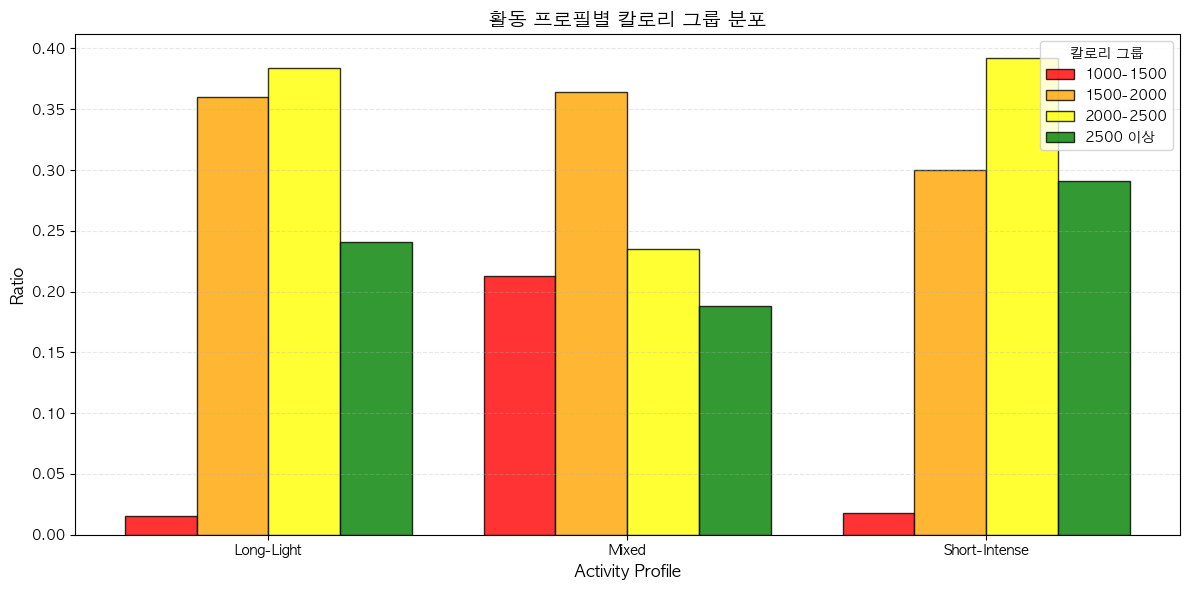

In [140]:
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(pivot_profile_cal.index))
width = 0.2
colors = ['red', 'orange', 'yellow', 'green']

# 각 칼로리 그룹별로 바 그리기
for i, col in enumerate(pivot_profile_cal.columns):
    offset = width * (i - 1.5)
    ax.bar([pos + offset for pos in x], 
           pivot_profile_cal[col], 
           width, 
           label=col,
           color=colors[i],
           edgecolor='black',
           alpha=0.8)

ax.set_xlabel('Activity Profile', fontsize=12, fontweight='bold')
ax.set_ylabel('Ratio', fontsize=12, fontweight='bold')
ax.set_title('활동 프로필별 칼로리 그룹 분포', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(pivot_profile_cal.index)
ax.legend(title='칼로리 그룹')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

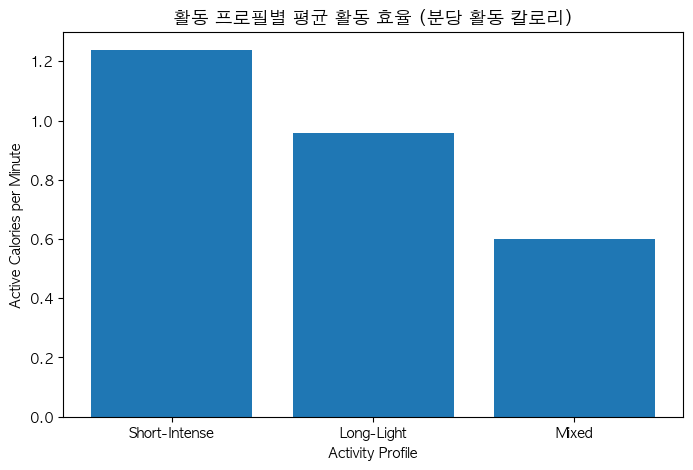

In [116]:
import matplotlib.pyplot as plt

# profile_eff 데이터프레임 사용
plt.figure(figsize=(8,5))
plt.bar(
    profile_eff['activity_profile'],
    profile_eff['ActiveCalPerMin']
)

plt.title('활동 프로필별 평균 활동 효율 (분당 활동 칼로리)', fontsize=13)
plt.xlabel('Activity Profile')
plt.ylabel('Active Calories per Minute')

plt.show()
